In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')
from empyrical import max_drawdown,cum_returns_final,cum_returns,sortino_ratio,sharpe_ratio,calmar_ratio,annual_return,annual_volatility

import matplotlib.pyplot as plt

import time
import datetime as dt
from datetime import timedelta
from pytz import timezone

import yfinance as yf
from datetime import date
import itertools as it

In [2]:
from platform import python_version

print(python_version())

3.7.4


# LOAD DATA V2

In [3]:
import_path = '/Users/niclaswolnerhanssen/Desktop/LINC/Sentiment LYNX/2_SIGNAL_PROCESSING/'

V2_TWITTER_ZSCORED                      = pd.read_excel(
    import_path+'V2_TWITTER_ZSCORED.xlsx',index_col=0)
V2_REDDIT_ZSCORED                       = pd.read_excel(
    import_path+'V2_REDDIT_ZSCORED.xlsx',index_col=0)
V2_BLOOMBERG_ZSCORED                    = pd.read_excel(
    import_path+'V2_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V2_TWITTER_REDDIT_ZSCORED               = pd.read_excel(
    import_path+'V2_TWITTER_REDDIT_ZSCORED.xlsx',index_col=0)
V2_TWITTER_REDDIT_BLOOMBERG_ZSCORED     = pd.read_excel(
    import_path+'V2_TWITTER_REDDIT_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V2_EMA_ZSCORED                          = pd.read_excel(
    import_path+'V2_EMA_ZSCORED.xlsx',index_col=0)
V2_EMA_TWITTER_ZSCORED                  = pd.read_excel(
    import_path+'V2_EMA_TWITTER_ZSCORED.xlsx',index_col=0)
V2_EMA_REDDIT_ZSCORED                   = pd.read_excel(
    import_path+'V2_EMA_REDDIT_ZSCORED.xlsx',index_col=0)
V2_EMA_BLOOMBERG_ZSCORED                = pd.read_excel(
    import_path+'V2_EMA_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V2_EMA_TWITTER_REDDIT_ZSCORED           = pd.read_excel(
    import_path+'V2_EMA_TWITTER_REDDIT_ZSCORED.xlsx',index_col=0)
V2_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED = pd.read_excel(
    import_path+'V2_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED.xlsx',index_col=0)
OPEN_TO_CLOSE_STOCK_RETURNS             = pd.read_excel(
    import_path+'V2_OPEN_TO_CLOSE_STOCK_RETURNS.xlsx',index_col=0)
OPEN_TO_CLOSE_EQUALW_RETURNS            = pd.read_excel(
    import_path+'V2_OPEN_TO_CLOSE_EQUALW_RETURNS.xlsx',index_col=0)
OPEN_TO_CLOSE_XLK_RETURNS               = pd.read_excel(
    import_path+'V2_OPEN_TO_CLOSE_XLK_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_STOCK_RETURNS              = pd.read_excel(
    import_path+'V2_OPEN_TO_OPEN_STOCK_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_EQUALW_RETURNS             = pd.read_excel(
    import_path+'V2_OPEN_TO_OPEN_EQUALW_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_XLK_RETURNS                = pd.read_excel(
    import_path+'V2_OPEN_TO_OPEN_XLK_RETURNS.xlsx',index_col=0)



In [4]:
signal_df_list = [

V2_TWITTER_ZSCORED,
V2_REDDIT_ZSCORED,
V2_BLOOMBERG_ZSCORED,
V2_EMA_ZSCORED,
V2_TWITTER_REDDIT_ZSCORED,
V2_TWITTER_REDDIT_BLOOMBERG_ZSCORED,
V2_EMA_TWITTER_ZSCORED,
V2_EMA_REDDIT_ZSCORED,
V2_EMA_BLOOMBERG_ZSCORED,
V2_EMA_TWITTER_REDDIT_ZSCORED,
V2_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED
    
 ]

# FUNCTIONS

In [5]:
def backtest_minmax(signal_df,returns_df,upper_q=0.5,lower_q = 0.5,min_stocks_each_basket = 1,extra_weight = 0.2):
    signal_df['RETURNS'] = returns_df['STOCK_RETURNS']
    #create date list
    date_list = signal_df['Date'].unique()
    feat_name = signal_df.columns[2]
    
    DATES = []
    TRADE_DATES = []
    MKT_NEUTRAL_RETURNS = []
    LONG_RETURNS = []
    SHORT_RETURNS = []
    DIAGNOSTICS = []
    
    
    for i in date_list:
        date_df = signal_df[signal_df['Date']==i]

        #create seperat long/short dfs by quantile
        long_date_df  = date_df[date_df[feat_name]>date_df.quantile(q=upper_q)[0]]
        short_date_df = date_df[date_df[feat_name]<date_df.quantile(q=lower_q)[0]]
        
        #There must be more stocks than min_stocks in each basket to trade 
        if (len(long_date_df)<min_stocks_each_basket)|(len(short_date_df)<min_stocks_each_basket):
            NO_VALUES = True

        else:
            NO_VALUES = False

        if NO_VALUES == True:
            DATES.append(i)
            MKT_NEUTRAL_RETURNS.append(0) 
            continue
        
        if len(long_date_df)==1:
            ONLY_1_LONG = True
        else:
            ONLY_1_LONG = False
            
        if len(short_date_df)==1:
            ONLY_1_SHORT = True 
        else:
            ONLY_1_SHORT = False
            
            
        ########WEIGHTS
        
        #SHORT
        short_date_df['MIN-MAX'] = ((short_date_df[feat_name]*-1) - (short_date_df[feat_name]*-1).min())/(
                                    (short_date_df[feat_name]*-1).max() - (short_date_df[feat_name]*-1).min())

        short_date_df['MIN-MAX'] = short_date_df['MIN-MAX']+extra_weight
        short_date_df['MIN-MAX-WEIGHT'] = short_date_df['MIN-MAX']/short_date_df['MIN-MAX'].sum()
        short_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(short_date_df))*-1

        #LONG
        long_date_df['MIN-MAX'] = ((long_date_df[feat_name]) - (long_date_df[feat_name]).min())/(
                                    (long_date_df[feat_name]).max() - (long_date_df[feat_name]).min())
        long_date_df['MIN-MAX'] = long_date_df['MIN-MAX']+extra_weight
        long_date_df['MIN-MAX-WEIGHT'] = long_date_df['MIN-MAX']/long_date_df['MIN-MAX'].sum()
        long_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(long_date_df)) 
        
        ########RETURNS
        
        if ONLY_1_LONG==True:
            long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER']
        else:
            long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER'] *long_date_df['MIN-MAX-WEIGHT']

        if ONLY_1_SHORT==True:
            short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']
        else:
            short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']*short_date_df['MIN-MAX-WEIGHT']

                
        ######APPEND
        
        #only on trading days (if min_stock is fulfilled)
        long_returns_date_sum = long_date_df['WEIGHTED RETURNS'].sum()#append
        LONG_RETURNS.append(long_returns_date_sum)
        
        short_returns_date_sum = short_date_df['WEIGHTED RETURNS'].sum()#append
        SHORT_RETURNS.append(short_returns_date_sum)
        
        total_returns_date_sum = long_returns_date_sum+short_returns_date_sum#append
        MKT_NEUTRAL_RETURNS.append(total_returns_date_sum)
        
        diagnostics_df = pd.concat([long_date_df,short_date_df]).sort_index()#append
        DIAGNOSTICS.append(diagnostics_df)
        
        TRADE_DATES.append(i)
        DATES.append(i)
        
    ##########pile to dfs
    
    STRATEGY_RETURNS            = pd.DataFrame(index=DATES)
    STRATEGY_RETURNS[feat_name] = MKT_NEUTRAL_RETURNS
    
    LS_RETURNS = pd.DataFrame(index=TRADE_DATES)
    LS_RETURNS[feat_name+'_LONG_RETURNS']  = LONG_RETURNS
    LS_RETURNS[feat_name+'_SHORT_RETURNS'] = SHORT_RETURNS
    
    #LS_returns only includes when returns when trading, so cumulative rets are going to be wrong, lets fix:
    LS_RETURNS = pd.concat([STRATEGY_RETURNS,LS_RETURNS],axis=1)
    LS_RETURNS = LS_RETURNS.drop(feat_name,axis=1)
    LS_RETURNS = LS_RETURNS.replace(np.nan,0)
    
    DIAGNOSTICS_DF = pd.concat(DIAGNOSTICS)
    
    return STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF
    
    

In [6]:
def backtest_rank(signal_df,returns_df,upper_q=0.5,lower_q = 0.5,min_stocks_each_basket = 1):
    signal_df['RETURNS'] = returns_df['STOCK_RETURNS']
    #create date list
    date_list = signal_df['Date'].unique()
    feat_name = signal_df.columns[2]
    
    DATES = []
    TRADE_DATES = []
    MKT_NEUTRAL_RETURNS = []
    LONG_RETURNS = []
    SHORT_RETURNS = []
    DIAGNOSTICS = []
    
    
    for i in date_list:
        date_df = signal_df[signal_df['Date']==i]

        #create seperat long/short dfs by quantile
        long_date_df  = date_df[date_df[feat_name]>date_df.quantile(q=upper_q)[0]]
        short_date_df = date_df[date_df[feat_name]<date_df.quantile(q=lower_q)[0]]
        
        #There must be more stocks than min_stocks in each basket to trade 
        if (len(long_date_df)<min_stocks_each_basket)|(len(short_date_df)<min_stocks_each_basket):
            NO_VALUES = True

        else:
            NO_VALUES = False

        if NO_VALUES==True:
            DATES.append(i)
            MKT_NEUTRAL_RETURNS.append(0) 
            continue
            
        ######## RANK WEIGHTS
        
        #SHORT
        short_date_df['ZSCORE RANK'] = short_date_df[feat_name].mul(-1).rank()
        short_date_df['RANK-WEIGHT'] = short_date_df['ZSCORE RANK']/short_date_df['ZSCORE RANK'].sum()
        short_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(short_date_df))*-1

        #LONG
        long_date_df['ZSCORE RANK'] = long_date_df[feat_name].rank()
        long_date_df['RANK-WEIGHT'] = long_date_df['ZSCORE RANK']/long_date_df['ZSCORE RANK'].sum()
        long_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(long_date_df))  
        
        ########RETURNS
        
        long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER'] *long_date_df['RANK-WEIGHT']
        short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']*short_date_df['RANK-WEIGHT']
    
        ######APPEND
        
        #only on trading days (if min_stock is fulfilled)
        long_returns_date_sum = long_date_df['WEIGHTED RETURNS'].sum()#append
        LONG_RETURNS.append(long_returns_date_sum)
        
        short_returns_date_sum = short_date_df['WEIGHTED RETURNS'].sum()#append
        SHORT_RETURNS.append(short_returns_date_sum)
        
        total_returns_date_sum = long_returns_date_sum+short_returns_date_sum#append
        MKT_NEUTRAL_RETURNS.append(total_returns_date_sum)
        
        diagnostics_df = pd.concat([long_date_df,short_date_df]).sort_index()#append
        DIAGNOSTICS.append(diagnostics_df)
        
        TRADE_DATES.append(i)
        DATES.append(i)
        
    ##########pile to dfs
    
    STRATEGY_RETURNS            = pd.DataFrame(index=DATES)
    STRATEGY_RETURNS[feat_name] = MKT_NEUTRAL_RETURNS
    
    LS_RETURNS = pd.DataFrame(index=TRADE_DATES)
    LS_RETURNS[feat_name+'_LONG_RETURNS']  = LONG_RETURNS
    LS_RETURNS[feat_name+'_SHORT_RETURNS'] = SHORT_RETURNS
    
    #LS_returns only includes when returns when trading, so cumulative rets are going to be wrong, lets fix:
    LS_RETURNS = pd.concat([STRATEGY_RETURNS,LS_RETURNS],axis=1)
    LS_RETURNS = LS_RETURNS.drop(feat_name,axis=1)
    LS_RETURNS = LS_RETURNS.replace(np.nan,0)
    
    DIAGNOSTICS_DF = pd.concat(DIAGNOSTICS)
    
    return STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF
    
    

In [7]:
def backtest_metrics(df):
    
    annualization=250       
    
    df_list = []
    for i in df.columns:
        df_series_ret = df[i]
        
        df_met = pd.DataFrame(index=['CAGR','Ann. Vol','Cumulative Ret.','MDD','Sharpe Ratio','Sortino Ratio','Calmar Ratio'])
        annual_ret = str( round(annual_return(df_series_ret,annualization=annualization)*100,2))+'%'
        annual_vol = str( round(annual_volatility(df_series_ret,annualization=annualization)*100,2))+'%'
        cum_ret = str( round(cum_returns_final(df_series_ret)*100,2))+'%'
        mdd= str( round(max_drawdown(df_series_ret)*100,2))+'%'
        sharpe = str( round(sharpe_ratio(df_series_ret,annualization=annualization),2))
        sort = str( round(sortino_ratio(df_series_ret,annualization=annualization),2))
        calmar = str( round(calmar_ratio(df_series_ret,annualization=annualization),2))

        df_met[df_series_ret.name] = [annual_ret,annual_vol,cum_ret,mdd,sharpe,sort,calmar]
        df_met = df_met.T
        df_list.append(df_met)
    
    df_2 = pd.concat(df_list)
    
    return df_2


In [8]:
def nr_of_trading_days(STRATEGY_RETURNS):
    NR_OF_ZERO_RETURNS_DAYS = len(STRATEGY_RETURNS[STRATEGY_RETURNS[STRATEGY_RETURNS.columns[0]]==0])
    NR_OF_DAYS = len(STRATEGY_RETURNS)

    return print('Nr of Trading Days, '+STRATEGY_RETURNS.columns[0]+' :'+str(round(100*(1-(NR_OF_ZERO_RETURNS_DAYS/NR_OF_DAYS)),2))+'%')


In [9]:
def total_number_of_trading_stocks(DIAGNOSTICS_DF):
    total = len(DIAGNOSTICS_DF['Stock'].unique())
    return print('Total Nr of stocks trading, '+DIAGNOSTICS_DF.columns[2]+': '+ str(total))

In [10]:
def stats_long_short(DIAGNOSTICS_DF):
    feat_name = DIAGNOSTICS_DF.columns[2]

    LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
    SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]

    Long_holdings = []
    for i in LONG_PORTFOLIOS['Date'].unique():
        nr_of_long_holdings_per_trading_day = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Date']==i])
        Long_holdings.append(nr_of_long_holdings_per_trading_day)

    Short_holdings = []
    for i in SHORT_PORTFOLIOS['Date'].unique():
        nr_of_short_holdings_per_trading_day = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Date']==i])
        Short_holdings.append(nr_of_short_holdings_per_trading_day)

    Long_mean = np.mean(Long_holdings)
    Long_min  = np.min(Long_holdings)
    Long_max  = np.max(Long_holdings)

    Short_mean = np.mean(Short_holdings)
    Short_min  = np.min(Short_holdings)
    Short_max  = np.max(Short_holdings)

    df = pd.DataFrame(index=['MEAN','MIN','MAX'])
    df['LONG BASKET NR. HOLDINGS, '+feat_name] = [Long_mean,Long_min,Long_max]
    df['SHORT BASKET NR. HOLDING, '+feat_name] = [Short_mean,Short_min,Short_max]
    return df


In [11]:
def top_10_stocks_traded(DIAGNOSTICS_DF):
    feat_name = DIAGNOSTICS_DF.columns[2]
    LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
    SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]
    
    #LONG BASKET
    LONG_ALLOCATION_NAME = []
    LONG_ALLOCATION_PERC = []
    for i in LONG_PORTFOLIOS['Stock'].unique():
        trade_days = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Stock']==i])
        long_days = len(LONG_PORTFOLIOS['Date'].unique())
        ratio = (trade_days/long_days)*100
        ratio = round(ratio,2)
        LONG_ALLOCATION_NAME.append(i)
        LONG_ALLOCATION_PERC.append(ratio)

    df_long = pd.DataFrame(index=LONG_ALLOCATION_NAME)
    df_long [feat_name+' LONG %'] = LONG_ALLOCATION_PERC
    df_long            = df_long.sort_values(feat_name+' LONG %',ascending=False)
    df_long            = df_long.iloc[0:10,]
    
    #SHORT BASKET
    SHORT_ALLOCATION_NAME = []
    SHORT_ALLOCATION_PERC = []
    for i in SHORT_PORTFOLIOS['Stock'].unique():
        trade_days = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Stock']==i])
        short_days = len(SHORT_PORTFOLIOS['Date'].unique())
        ratio = (trade_days/short_days)*100
        ratio = round(ratio,2)
        SHORT_ALLOCATION_NAME.append(i)
        SHORT_ALLOCATION_PERC.append(ratio)

    df_short = pd.DataFrame(index=SHORT_ALLOCATION_NAME)
    df_short [feat_name+' SHORT %'] = SHORT_ALLOCATION_PERC
    df_short            = df_short.sort_values(feat_name+' SHORT %',ascending=False)
    df_short            = df_short.iloc[0:10,]
    
    #DISPLAY STUFF
    
    from IPython.display import display_html
    from itertools import chain,cycle
    def display_side_by_side(*args,titles=cycle([''])):
        html_str=''
        for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
            html_str+='<th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h2>{title}</h2>'
            html_str+=df.to_html().replace('table','table style="display:inline"')
            html_str+='</td></th>'
        display_html(html_str,raw=True)
        
    return display_side_by_side(df_long,df_short)
    

In [12]:
def turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES'):
    
    ###In percentage terms how many stocks are replaced on average each day in the basket?
    ### if ALL_DAYS='YES', calculate all based on all trading days, else just calculate when trading
    
    if BASKET=='LONG':
        DIRECTION = 1
    else:
        DIRECTION = -1

    stocks_in_basket_list = []
    
    if ALL_DAYS=='YES':

        for i in STRATEGY_RETURNS.index:

                DIA = DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']==i]
                DIA_LONG = DIA[DIA['LONG/SHORT MULTIPLIER']==DIRECTION]
                STOCKS_IN_T0 = DIA_LONG['Stock'].values
                stocks_in_basket_list.append(STOCKS_IN_T0)
                
                
    else:
        
        for i in DIAGNOSTICS_DF['Date'].unique():

                DIA = DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']==i]
                DIA_LONG = DIA[DIA['LONG/SHORT MULTIPLIER']==DIRECTION]
                STOCKS_IN_T0 = DIA_LONG['Stock'].values
                stocks_in_basket_list.append(STOCKS_IN_T0)
        


    turnover_percent = []
    for i in range(0,len(stocks_in_basket_list)):
        if i != len(stocks_in_basket_list)-1:
            nr_stocks_in_t0 = len(stocks_in_basket_list[i])
            nr_stocks_in_t1 = len(stocks_in_basket_list[i+1])

            #if there is no stocks in first period but stock in next, the turnover is 100% for that day
            if (nr_stocks_in_t0 == 0)&(nr_stocks_in_t1!=0):
                percentage_of_stocks_new_in_t1 = 1.0
            #if there is no stocks in second period but stock in period before, the turnover is 100% for that day
            elif (nr_stocks_in_t0 !=0)&(nr_stocks_in_t1==0):
                percentage_of_stocks_new_in_t1 = 1.0       

            else:
                #nr of intersected stocks
                nr_stocks_from_t0_still_in_t1 = len(list(set(stocks_in_basket_list[i]) & set(stocks_in_basket_list[i+1])))
                nr_total_stocks_in_t1 = len(stocks_in_basket_list[i+1])

                if nr_total_stocks_in_t1 != 0:
                    percentage_of_stocks_new_in_t1 = 1-(nr_stocks_from_t0_still_in_t1/nr_total_stocks_in_t1)
                else:
                    percentage_of_stocks_new_in_t1 = 0


            turnover_percent.append(percentage_of_stocks_new_in_t1)  

    mean_turnover = round(np.mean(turnover_percent),2)
    
    if BASKET=='LONG':
        if ALL_DAYS=='YES':
            string = 'Mean Turnover, Long Basket, All days, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)
            
        else:
            string = 'Mean Turnover, Long Basket, trading days only, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)
    else:
        if ALL_DAYS=='YES':
            string = 'Mean Turnover, Short Basket, All days, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)
            
        else:
            string = 'Mean Turnover, Short Basket, trading days only, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)

    return print(string)

    

# OPEN TO CLOSE

In [13]:
upper_q = 0.5
lower_q = 0.5
min_stocks_each_basket = 1
extra_weight = 0.2 # in min-max weighting due to min value is removed from the lowest value, 
                   #making the smallest value having zero weight which is a problem
                   # when the number of stocks in each basket is small.
        
returns_df = OPEN_TO_CLOSE_STOCK_RETURNS.copy()

# ZSCORE WEIGHTED

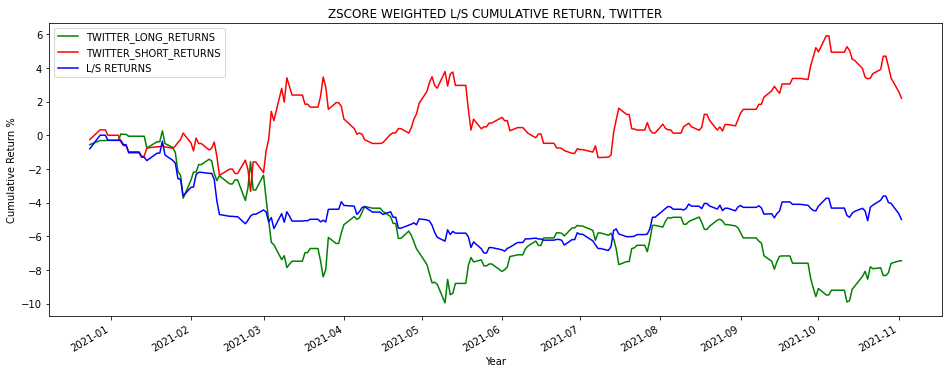

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS   -8.58%    8.17%          -7.46%  -10.2%        -1.06   
TWITTER_SHORT_RETURNS   2.55%    7.88%            2.2%  -4.93%         0.36   
L/S RETURNS            -5.77%    5.23%          -5.01%   -7.0%        -1.11   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS           -1.4        -0.84  
TWITTER_SHORT_RETURNS          0.55         0.52  
L/S RETURNS                   -1.48        -0.82

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 38


TWITTER LONG % 
 
 
 
 
 CSCO 
 56.10 
 
 
 PAYC 
 54.88 
 
 
 ADSK 
 54.27 
 
 
 LRCX 
 52.44 
 
 
 QCOM 
 51.22 
 
 
 ADP 
 50.00 
 
 
 ORCL 
 49.39 
 
 
 CRM 
 48.78 
 
 
 ADI 
 48.78 
 
 
 MSFT 
 47.56 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 INTC 
 65.24 
 
 
 TER 
 58.54 
 
 
 PYPL 
 57.93 
 
 
 NVDA 
 57.32 
 
 
 AAPL 
 56.10 
 
 
 AMD 
 53.66 
 
 
 ADBE 
 51.22 
 
 
 MSFT 
 51.22 
 
 
 WDC 
 50.00 
 
 
 ADI 
 50.00

Mean Turnover, Long Basket, All days, TWITTER: 0.49
Mean Turnover, Short Basket, All days, TWITTER: 0.48
Mean Turnover, Long Basket, trading days only, TWITTER: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER: 0.21


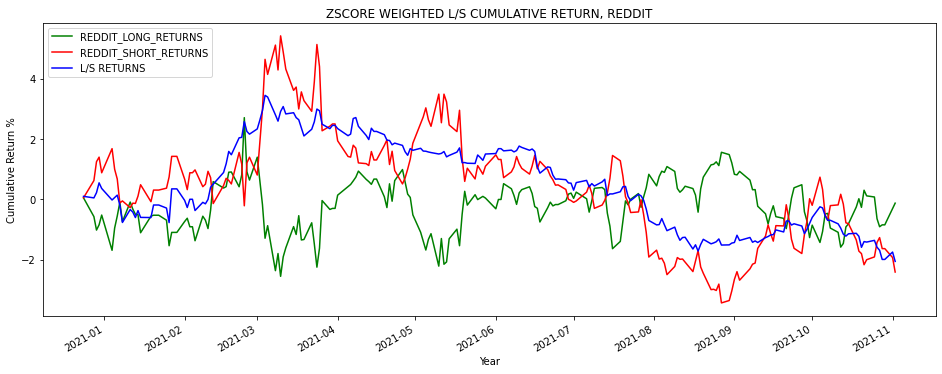

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS   -0.15%    7.82%          -0.13%  -5.12%         0.02   
REDDIT_SHORT_RETURNS  -2.79%    8.08%          -2.41%   -8.4%        -0.31   
L/S RETURNS           -2.38%    3.57%          -2.06%  -5.32%        -0.66   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS           0.03        -0.03  
REDDIT_SHORT_RETURNS         -0.44        -0.33  
L/S RETURNS                  -0.95        -0.45

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 65


REDDIT LONG % 
 
 
 
 
 AVGO 
 58.45 
 
 
 HPQ 
 58.45 
 
 
 AKAM 
 57.97 
 
 
 TDY 
 57.49 
 
 
 APH 
 56.52 
 
 
 MSI 
 56.04 
 
 
 FTNT 
 55.07 
 
 
 ADBE 
 54.59 
 
 
 SWKS 
 54.11 
 
 
 ENPH 
 53.14 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 CSCO 
 61.35 
 
 
 SNPS 
 61.35 
 
 
 AAPL 
 59.90 
 
 
 ORCL 
 59.90 
 
 
 WDC 
 57.97 
 
 
 ADP 
 57.49 
 
 
 MSFT 
 57.00 
 
 
 IBM 
 56.52 
 
 
 HPE 
 56.04 
 
 
 AMD 
 55.07

Mean Turnover, Long Basket, All days, REDDIT: 0.26
Mean Turnover, Short Basket, All days, REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, REDDIT: 0.2
Mean Turnover, Short Basket, trading days only, REDDIT: 0.21


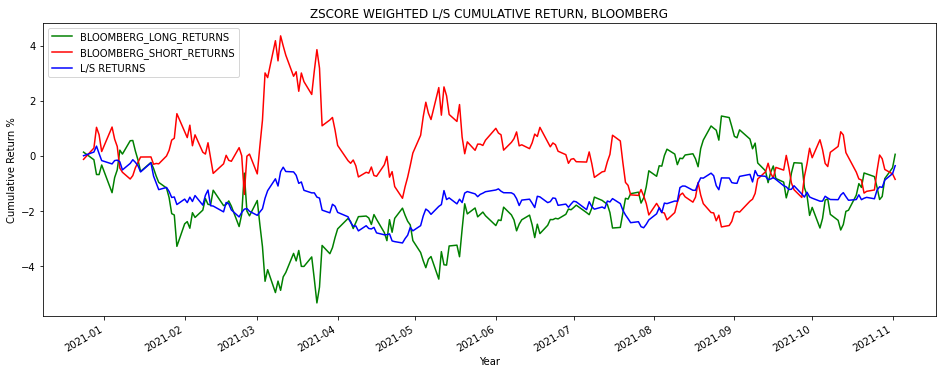

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
BLOOMBERG_LONG_RETURNS    0.06%    7.33%           0.05%  -5.87%         0.04   
BLOOMBERG_SHORT_RETURNS  -0.99%    7.75%          -0.86%  -6.65%        -0.09   
L/S RETURNS              -0.42%    3.13%          -0.36%  -3.51%        -0.12   

                        Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS           0.06         0.01  
BLOOMBERG_SHORT_RETURNS         -0.13        -0.15  
L/S RETURNS                     -0.17        -0.12

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 NVDA 
 57.87 
 
 
 V 
 57.41 
 
 
 FISV 
 57.41 
 
 
 MA 
 57.41 
 
 
 INTC 
 56.48 
 
 
 QCOM 
 54.63 
 
 
 FTNT 
 54.63 
 
 
 AMD 
 54.17 
 
 
 TXN 
 54.17 
 
 
 ORCL 
 54.17 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 59.72 
 
 
 KEYS 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 DXC 
 56.48 
 
 
 QRVO 
 56.02 
 
 
 CDW 
 55.56 
 
 
 JKHY 
 55.56 
 
 
 PTC 
 55.09 
 
 
 NTAP 
 54.63 
 
 
 PAYC 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.2
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


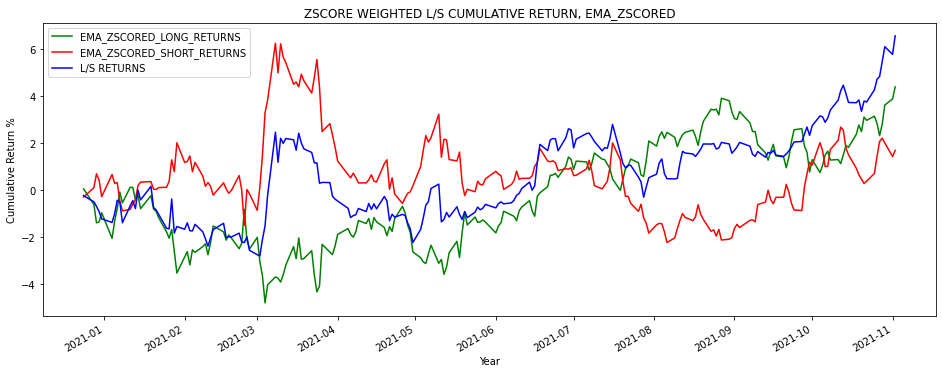

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_ZSCORED_LONG_RETURNS   5.11%    7.78%            4.4%  -4.92%   
EMA_ZSCORED_SHORT_RETURNS  1.97%    8.89%            1.7%  -7.98%   
L/S RETURNS                7.65%    7.23%           6.57%  -4.58%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          0.68           1.0         1.04  
EMA_ZSCORED_SHORT_RETURNS         0.26          0.39         0.25  
L/S RETURNS                       1.06          1.62         1.67

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


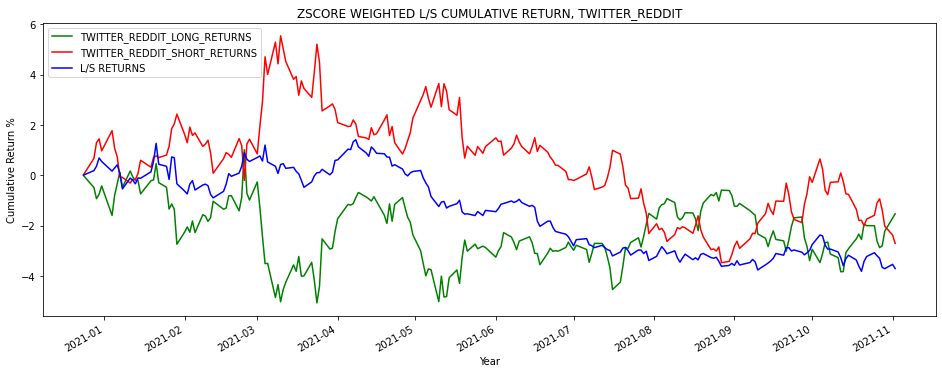

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_LONG_RETURNS   -1.77%    8.32%          -1.53%  -6.02%   
TWITTER_REDDIT_SHORT_RETURNS  -3.13%    8.05%          -2.71%  -8.54%   
L/S RETURNS                   -4.28%     3.9%          -3.71%  -5.15%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS         -0.17         -0.24        -0.29  
TWITTER_REDDIT_SHORT_RETURNS        -0.35          -0.5        -0.37  
L/S RETURNS                          -1.1         -1.47        -0.83

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 69


TWITTER_REDDIT LONG % 
 
 
 
 
 HPQ 
 63.43 
 
 
 AKAM 
 57.41 
 
 
 CRM 
 55.09 
 
 
 FTNT 
 55.09 
 
 
 SWKS 
 53.70 
 
 
 QCOM 
 52.31 
 
 
 TER 
 52.31 
 
 
 MSI 
 50.93 
 
 
 BR 
 50.46 
 
 
 NTAP 
 49.54 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 SNPS 
 59.72 
 
 
 HPE 
 57.41 
 
 
 ADBE 
 55.56 
 
 
 AAPL 
 55.09 
 
 
 PYPL 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 AMD 
 54.17 
 
 
 NVDA 
 54.17 
 
 
 INTU 
 54.17 
 
 
 GLW 
 53.70

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.26


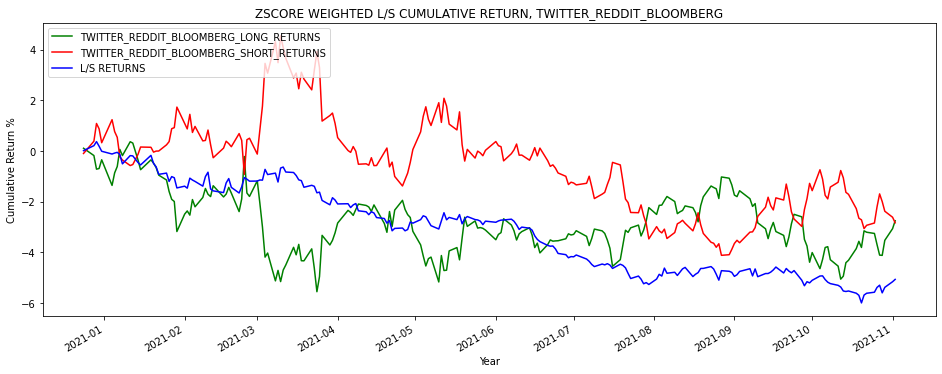

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS   -3.17%    7.57%          -2.75%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -3.27%    7.68%          -2.83%   
L/S RETURNS                             -5.84%    2.96%          -5.06%   

                                           MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS    -5.9%        -0.39         -0.54   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -8.28%        -0.39         -0.56   
L/S RETURNS                             -6.34%        -2.01         -2.65   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS         -0.54  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -0.39  
L/S RETURNS                                   -0.92

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 59.26 
 
 
 MSI 
 58.33 
 
 
 MA 
 57.41 
 
 
 AVGO 
 56.94 
 
 
 FISV 
 56.48 
 
 
 TXN 
 56.02 
 
 
 QCOM 
 56.02 
 
 
 TYL 
 55.56 
 
 
 QRVO 
 55.09 
 
 
 HPQ 
 54.63 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 KEYS 
 59.72 
 
 
 ADBE 
 59.26 
 
 
 ANSS 
 58.33 
 
 
 DXC 
 57.41 
 
 
 TRMB 
 56.02 
 
 
 INTU 
 56.02 
 
 
 ZBRA 
 55.56 
 
 
 PYPL 
 55.56 
 
 
 SNPS 
 55.09 
 
 
 CDAY 
 54.63

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


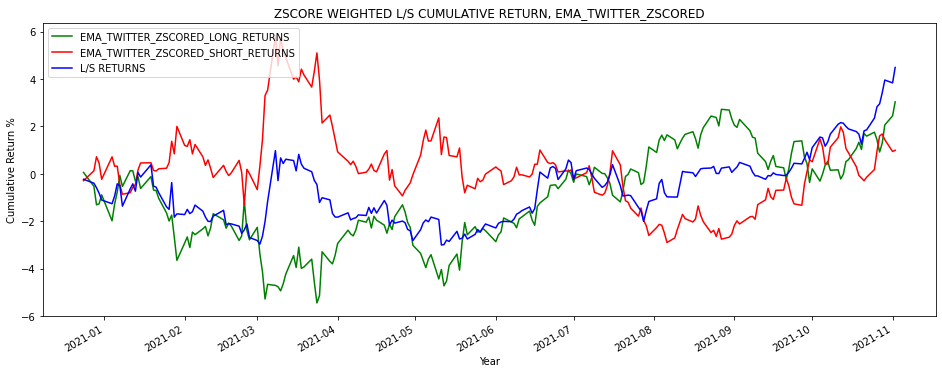

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS   3.52%    7.87%           3.03%  -5.57%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  1.15%    8.56%           0.99%  -8.23%   
L/S RETURNS                        5.21%    6.28%           4.49%  -3.94%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          0.48           0.7         0.63  
EMA_TWITTER_ZSCORED_SHORT_RETURNS         0.18          0.26         0.14  
L/S RETURNS                               0.84          1.26         1.32

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MPWR 
 63.89 
 
 
 IT 
 63.89 
 
 
 INTU 
 62.04 
 
 
 HPQ 
 60.19 
 
 
 PAYX 
 59.26 
 
 
 PAYC 
 59.26 
 
 
 MSI 
 59.26 
 
 
 CRM 
 57.87 
 
 
 ANET 
 57.41 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 WU 
 64.81 
 
 
 FISV 
 64.35 
 
 
 CTXS 
 63.89 
 
 
 FIS 
 62.50 
 
 
 GLW 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 GPN 
 59.72 
 
 
 VRSN 
 58.80 
 
 
 WDC 
 57.87 
 
 
 MU 
 57.87

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21


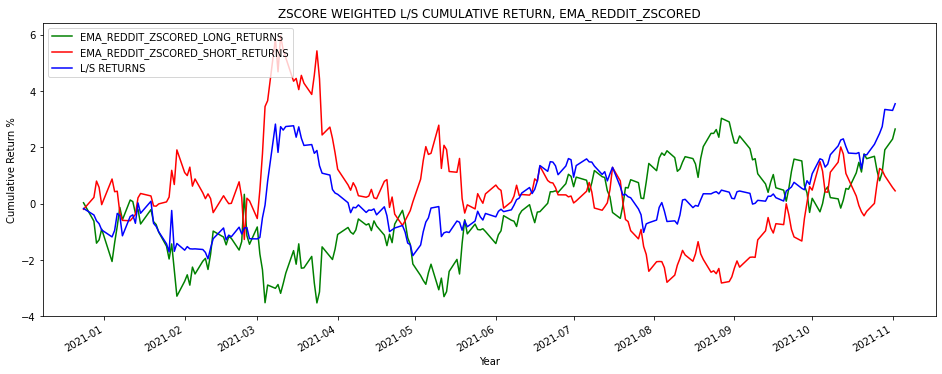

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS   3.07%    7.65%           2.65%  -3.85%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  0.52%    8.52%           0.45%  -8.29%   
L/S RETURNS                       4.12%    5.76%           3.55%  -4.55%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          0.43          0.63          0.8  
EMA_REDDIT_ZSCORED_SHORT_RETURNS          0.1          0.15         0.06  
L/S RETURNS                              0.73          1.12         0.91

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 68.98 
 
 
 MSI 
 66.20 
 
 
 TXN 
 62.04 
 
 
 MPWR 
 60.19 
 
 
 HPQ 
 59.26 
 
 
 AVGO 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 TRMB 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 TDY 
 57.41 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 GPN 
 68.52 
 
 
 CTXS 
 63.89 
 
 
 CSCO 
 62.96 
 
 
 IPGP 
 61.57 
 
 
 ADI 
 60.19 
 
 
 WDC 
 59.72 
 
 
 IBM 
 59.72 
 
 
 FIS 
 59.72 
 
 
 FLT 
 59.26 
 
 
 FISV 
 56.94

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


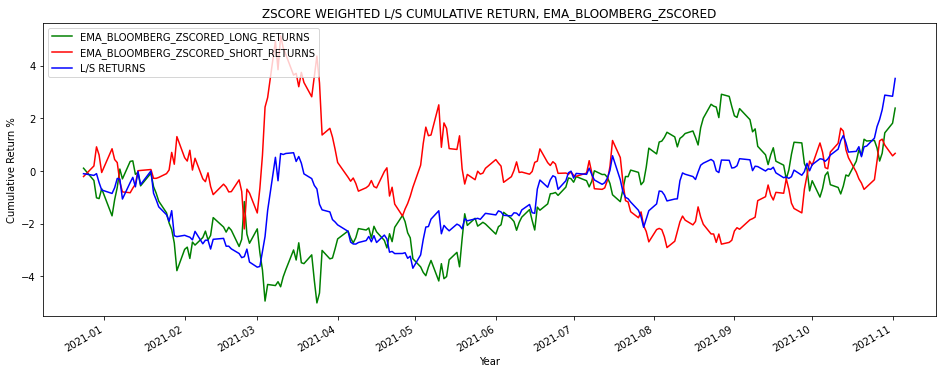

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS   2.77%    7.44%           2.39%  -5.37%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  0.78%    8.59%           0.67%  -7.64%   
L/S RETURNS                          4.08%    5.53%           3.51%  -4.35%   

                                    Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS           0.4          0.59         0.52  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS         0.13           0.2          0.1  
L/S RETURNS                                 0.75          1.19         0.94

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 66.20 
 
 
 IT 
 59.72 
 
 
 MPWR 
 58.33 
 
 
 NVDA 
 57.87 
 
 
 INTU 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 ZBRA 
 56.02 
 
 
 ANET 
 55.09 
 
 
 XLNX 
 54.63 
 
 
 KLAC 
 54.63 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 62.50 
 
 
 AKAM 
 59.26 
 
 
 GPN 
 57.87 
 
 
 CTSH 
 56.94 
 
 
 NLOK 
 56.94 
 
 
 VRSN 
 56.48 
 
 
 ANSS 
 55.09 
 
 
 HPQ 
 54.17 
 
 
 WU 
 54.17 
 
 
 TDY 
 53.70

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


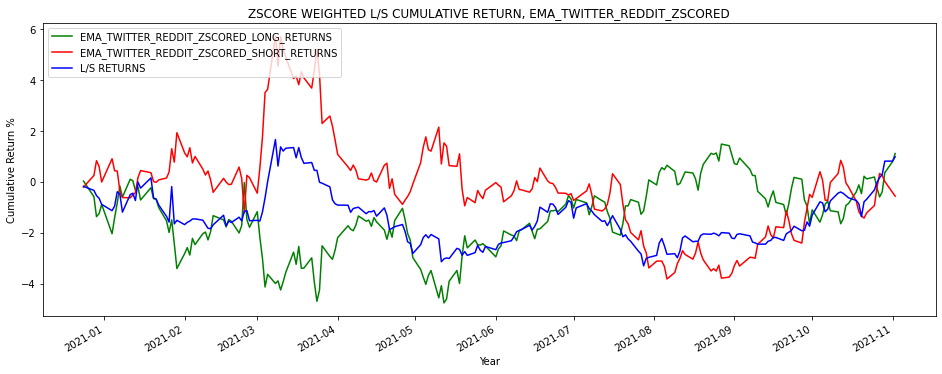

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    1.28%    7.72%           1.11%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -0.65%    8.36%          -0.56%   
L/S RETURNS                                1.13%    5.26%           0.98%   

                                             MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   -4.85%          0.2          0.29   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -9.02%        -0.04         -0.05   
L/S RETURNS                               -4.87%         0.24          0.35   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          0.27  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS        -0.07  
L/S RETURNS                                      0.23

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.83 
 
 
 MSI 
 65.28 
 
 
 HPQ 
 65.28 
 
 
 MPWR 
 61.57 
 
 
 ANET 
 59.26 
 
 
 AKAM 
 58.80 
 
 
 IT 
 56.94 
 
 
 INTU 
 56.94 
 
 
 TRMB 
 56.94 
 
 
 TXN 
 56.48 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 66.20 
 
 
 GPN 
 63.43 
 
 
 FISV 
 59.72 
 
 
 FIS 
 59.72 
 
 
 IPGP 
 58.80 
 
 
 WU 
 57.41 
 
 
 FLT 
 56.94 
 
 
 JNPR 
 56.94 
 
 
 WDC 
 56.94 
 
 
 PYPL 
 56.94

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21


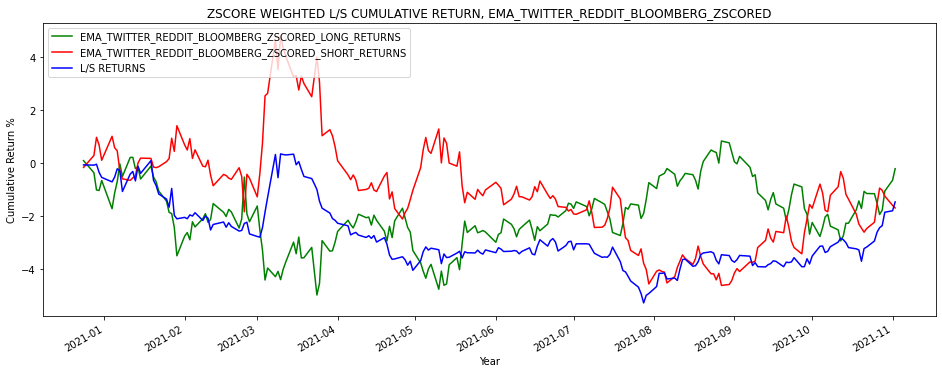

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS   -0.24%    7.47%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -1.96%    8.28%   
L/S RETURNS                                          -1.7%    4.61%   

                                                   Cumulative Ret.     MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS           -0.21%   -5.2%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS           -1.7%  -9.01%   
L/S RETURNS                                                 -1.47%  -5.62%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS           0.0          0.01   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         -0.2         -0.29   
L/S RETURNS                                               -0.35         -0.51   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS         -0.05  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -0.22  
L/S RETURNS                                                -0.3

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 71.76 
 
 
 MSI 
 58.80 
 
 
 MPWR 
 58.33 
 
 
 IT 
 57.87 
 
 
 TYL 
 56.02 
 
 
 ANET 
 56.02 
 
 
 AVGO 
 55.56 
 
 
 TXN 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 CDNS 
 54.63 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 65.74 
 
 
 ADBE 
 57.87 
 
 
 GPN 
 56.94 
 
 
 WU 
 56.48 
 
 
 FIS 
 56.48 
 
 
 WDC 
 55.56 
 
 
 KEYS 
 55.56 
 
 
 CTSH 
 54.63 
 
 
 IPGP 
 54.17 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22


In [14]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_minmax(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                     extra_weight           = extra_weight
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('ZSCORE WEIGHTED L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000 -0.110734   0.182587     0.021321       0.045040   
REDDIT        -0.110734  1.000000  -0.093664     0.015162      -0.114981   
BLOOMBERG      0.182587 -0.093664   1.000000     0.259854      -0.148646   
EMA_ZSCORED    0.021321  0.015162   0.259854     1.000000      -0.178212   
EQUAL_RETURNS  0.045040 -0.114981  -0.148646    -0.178212       1.000000   
XLK_RETURNS    0.093901 -0.148813  -0.087175    -0.158282       0.884616   

               XLK_RETURNS  
TWITTER           0.093901  
REDDIT           -0.148813  
BLOOMBERG        -0.087175  
EMA_ZSCORED      -0.158282  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

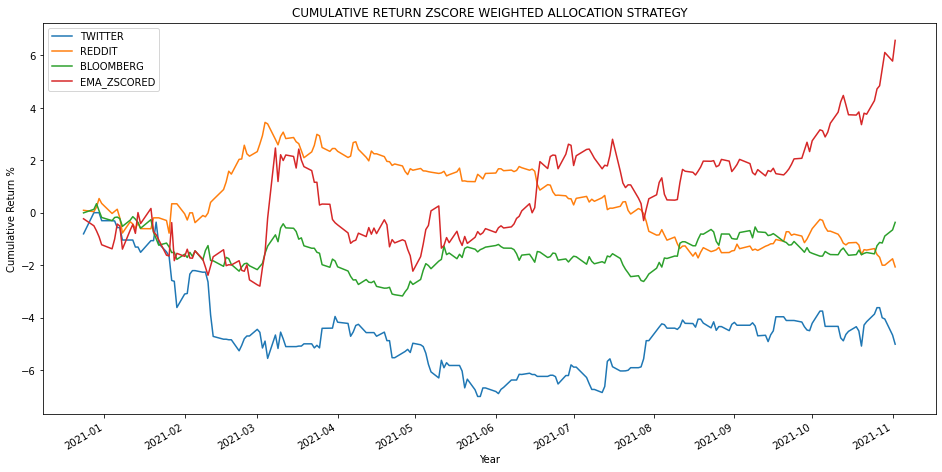

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -5.77%    5.23%          -5.01%   -7.0%        -1.11   
REDDIT       -2.38%    3.57%          -2.06%  -5.32%        -0.66   
BLOOMBERG    -0.42%    3.13%          -0.36%  -3.51%        -0.12   
EMA_ZSCORED   7.65%    7.23%           6.57%  -4.58%         1.06   

            Sortino Ratio Calmar Ratio  
TWITTER             -1.48        -0.82  
REDDIT              -0.95        -0.45  
BLOOMBERG           -0.17        -0.12  
EMA_ZSCORED          1.62         1.67

In [15]:
singles = zscore_returns[0:4]
singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))


TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.127244   
EMA_REDDIT_ZSCORED                                    0.197815   
EMA_BLOOMBERG_ZSCORED                                 0.307743   
EMA_TWITTER_REDDIT_ZSCORED                            0.263227   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.519212   
EQUAL_RETURNS                                        -0.047078   
XLK_RETURNS                                          -0.012343   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.127244            0.197815   
EMA_TWITTER_ZSCORED                              1.000000            0.910836   
EMA_REDDIT_ZSCORED                               0.910836            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.892744            0.846872   
EMA_TWITTER_REDDIT_ZSCORED                       0.933913            0.971815   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.880851            0.885034   
EQUAL_RETURNS                                   -0.120125           -0.169662   
XLK_RETURNS                                     -0.100590           -0.173735   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.307743   
EMA_TWITTER_ZSCORED                                0.892744   
EMA_REDDIT_ZSCORED                                 0.846872   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.818991   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.931238   
EQUAL_RETURNS                                     -0.200042   
XLK_RETURNS                                       -0.161238   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.263227   
EMA_TWITTER_ZSCORED                                     0.933913   
EMA_REDDIT_ZSCORED                                      0.971815   
EMA_BLOOMBERG_ZSCORED                                   0.818991   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.902502   
EQUAL_RETURNS                                          -0.131682   
XLK_RETURNS                                            -0.131276   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.519212   
EMA_TWITTER_ZSCORED                                               0.880851   
EMA_REDDIT_ZSCORED                                                0.885034   
EMA_BLOOMBERG_ZSCORED                                             0.931238   
EMA_TWITTER_REDDIT_ZSCORED                                        0.902502   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.162556   
XLK_RETURNS                                                      -0.137244   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                  -0.047078    -0.012343  
EMA_TWITTER_ZSCORED                       -0.120125    -0.100590  
EMA_REDDIT_ZSCORED                        -0.169662    -0.173735  
EMA_BLOOMBERG_ZSCORED                     -0.200042    -0.161238  
EMA_TWITTER_REDDIT_ZSCORED                -0.131682    -0.131276  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.162556    -0.137244  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

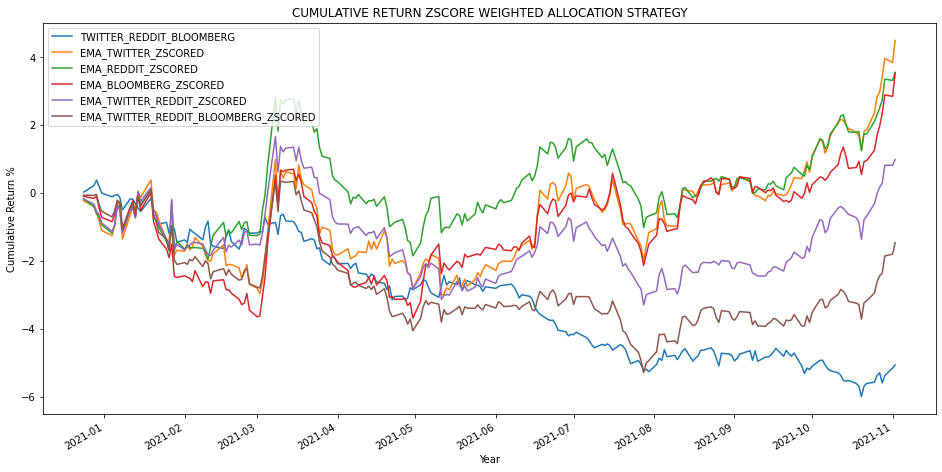

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -5.84%    2.96%          -5.06%  -6.34%   
EMA_TWITTER_ZSCORED                    5.21%    6.28%           4.49%  -3.94%   
EMA_REDDIT_ZSCORED                     4.12%    5.76%           3.55%  -4.55%   
EMA_BLOOMBERG_ZSCORED                  4.08%    5.53%           3.51%  -4.35%   
EMA_TWITTER_REDDIT_ZSCORED             1.13%    5.26%           0.98%  -4.87%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED   -1.7%    4.61%          -1.47%  -5.62%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -2.01         -2.65        -0.92  
EMA_TWITTER_ZSCORED                          0.84          1.26         1.32  
EMA_REDDIT_ZSCORED                           0.73          1.12         0.91  
EMA_BLOOMBERG_ZSCORED                        0.75          1.19         0.94  
EMA_TWITTER_REDDIT_ZSCORED                   0.24          0.35         0.23  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED        -0.35         -0.51         -0.3

In [16]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))

# RANK WEIGHTED

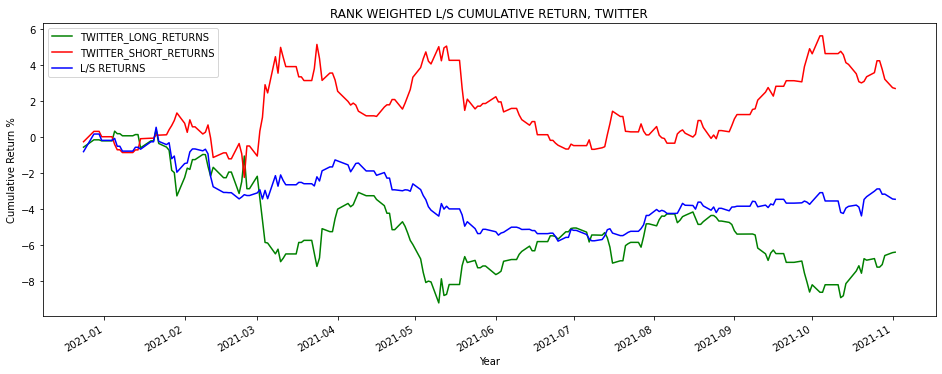

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS   -7.35%    7.83%          -6.39%  -9.58%        -0.94   
TWITTER_SHORT_RETURNS   3.14%    7.78%           2.71%  -5.54%         0.44   
L/S RETURNS            -3.98%    4.98%          -3.45%  -6.29%        -0.79   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS          -1.23        -0.77  
TWITTER_SHORT_RETURNS          0.68         0.57  
L/S RETURNS                   -1.09        -0.63

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 38


TWITTER LONG % 
 
 
 
 
 CSCO 
 56.10 
 
 
 PAYC 
 54.88 
 
 
 ADSK 
 54.27 
 
 
 LRCX 
 52.44 
 
 
 QCOM 
 51.22 
 
 
 ADP 
 50.00 
 
 
 ORCL 
 49.39 
 
 
 CRM 
 48.78 
 
 
 ADI 
 48.78 
 
 
 MSFT 
 47.56 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 INTC 
 65.24 
 
 
 TER 
 58.54 
 
 
 PYPL 
 57.93 
 
 
 NVDA 
 57.32 
 
 
 AAPL 
 56.10 
 
 
 AMD 
 53.66 
 
 
 ADBE 
 51.22 
 
 
 MSFT 
 51.22 
 
 
 WDC 
 50.00 
 
 
 ADI 
 50.00

Mean Turnover, Long Basket, All days, TWITTER: 0.49
Mean Turnover, Short Basket, All days, TWITTER: 0.48
Mean Turnover, Long Basket, trading days only, TWITTER: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER: 0.21


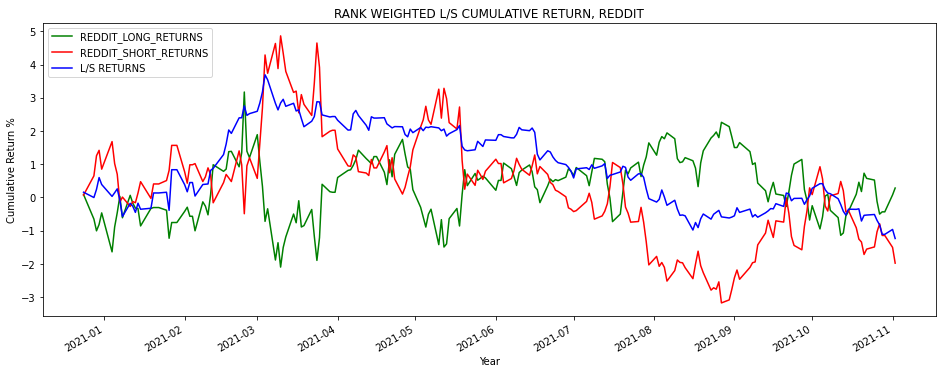

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS    0.33%    7.69%           0.28%  -5.11%         0.08   
REDDIT_SHORT_RETURNS  -2.29%    7.98%          -1.98%  -7.67%        -0.25   
L/S RETURNS           -1.43%     3.6%          -1.24%  -4.75%        -0.38   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS           0.11         0.06  
REDDIT_SHORT_RETURNS         -0.35         -0.3  
L/S RETURNS                  -0.55         -0.3

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 65


REDDIT LONG % 
 
 
 
 
 AVGO 
 58.45 
 
 
 HPQ 
 58.45 
 
 
 AKAM 
 57.97 
 
 
 TDY 
 57.49 
 
 
 APH 
 56.52 
 
 
 MSI 
 56.04 
 
 
 FTNT 
 55.07 
 
 
 ADBE 
 54.59 
 
 
 SWKS 
 54.11 
 
 
 ENPH 
 53.14 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 CSCO 
 61.35 
 
 
 SNPS 
 61.35 
 
 
 AAPL 
 59.90 
 
 
 ORCL 
 59.90 
 
 
 WDC 
 57.97 
 
 
 ADP 
 57.49 
 
 
 MSFT 
 57.00 
 
 
 IBM 
 56.52 
 
 
 HPE 
 56.04 
 
 
 AMD 
 55.07

Mean Turnover, Long Basket, All days, REDDIT: 0.26
Mean Turnover, Short Basket, All days, REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, REDDIT: 0.2
Mean Turnover, Short Basket, trading days only, REDDIT: 0.21


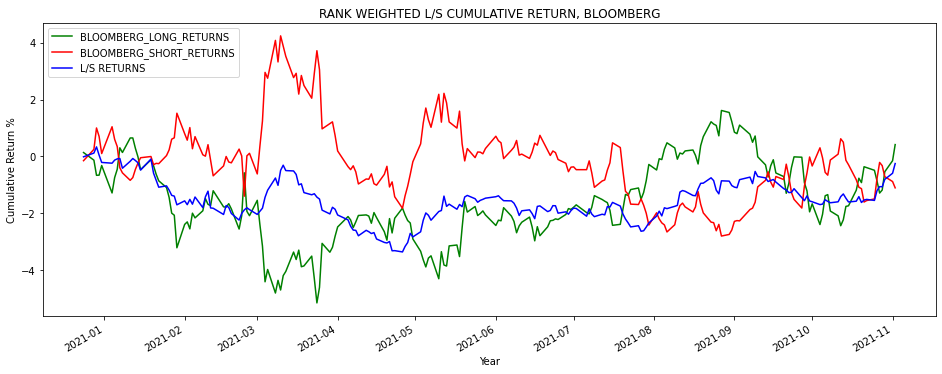

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
BLOOMBERG_LONG_RETURNS    0.48%    7.32%           0.42%  -5.77%          0.1   
BLOOMBERG_SHORT_RETURNS  -1.28%    7.76%          -1.11%  -6.76%        -0.13   
L/S RETURNS              -0.29%     3.2%          -0.25%  -3.69%        -0.07   

                        Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS           0.15         0.08  
BLOOMBERG_SHORT_RETURNS         -0.18        -0.19  
L/S RETURNS                     -0.11        -0.08

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 NVDA 
 57.87 
 
 
 V 
 57.41 
 
 
 FISV 
 57.41 
 
 
 MA 
 57.41 
 
 
 INTC 
 56.48 
 
 
 QCOM 
 54.63 
 
 
 FTNT 
 54.63 
 
 
 AMD 
 54.17 
 
 
 TXN 
 54.17 
 
 
 ORCL 
 54.17 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 59.72 
 
 
 KEYS 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 DXC 
 56.48 
 
 
 QRVO 
 56.02 
 
 
 CDW 
 55.56 
 
 
 JKHY 
 55.56 
 
 
 PTC 
 55.09 
 
 
 NTAP 
 54.63 
 
 
 PAYC 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.2
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


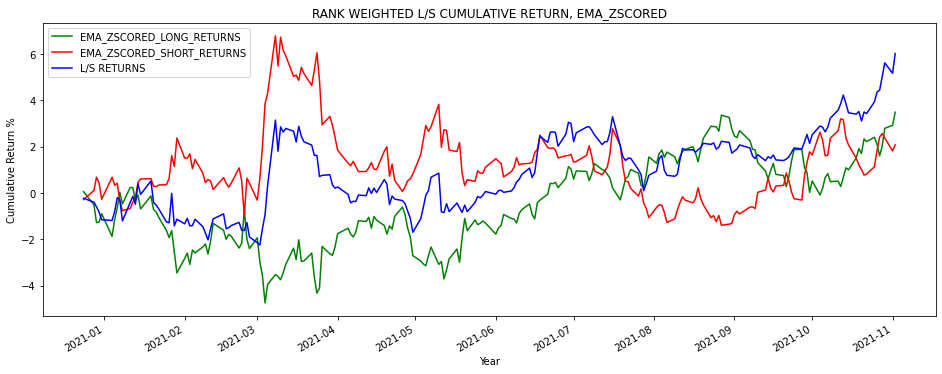

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_ZSCORED_LONG_RETURNS   4.05%    7.71%           3.49%  -4.98%   
EMA_ZSCORED_SHORT_RETURNS  2.41%    8.92%           2.08%  -7.67%   
L/S RETURNS                7.01%    7.37%           6.03%   -4.7%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          0.55          0.81         0.81  
EMA_ZSCORED_SHORT_RETURNS         0.31          0.46         0.31  
L/S RETURNS                       0.96          1.46         1.49

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


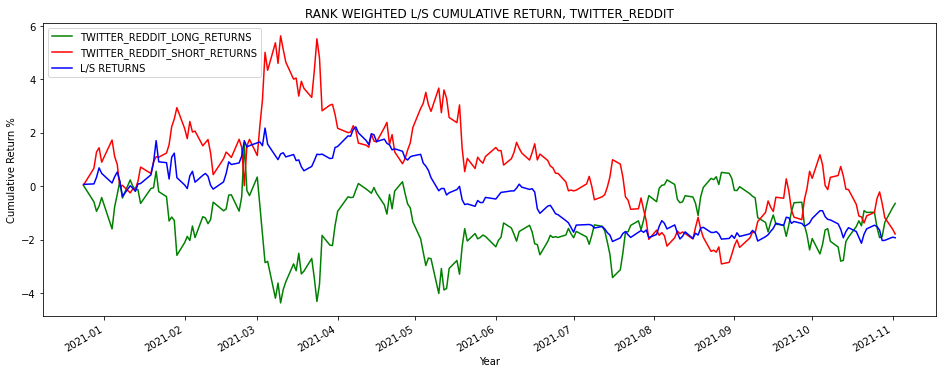

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_LONG_RETURNS   -0.75%    8.27%          -0.64%  -5.86%   
TWITTER_REDDIT_SHORT_RETURNS  -2.07%    7.95%          -1.79%  -8.08%   
L/S RETURNS                   -2.23%    3.83%          -1.93%  -4.26%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS         -0.05         -0.07        -0.13  
TWITTER_REDDIT_SHORT_RETURNS        -0.22         -0.31        -0.26  
L/S RETURNS                         -0.57         -0.78        -0.52

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 69


TWITTER_REDDIT LONG % 
 
 
 
 
 HPQ 
 63.43 
 
 
 AKAM 
 57.41 
 
 
 CRM 
 55.09 
 
 
 FTNT 
 55.09 
 
 
 SWKS 
 53.70 
 
 
 QCOM 
 52.31 
 
 
 TER 
 52.31 
 
 
 MSI 
 50.93 
 
 
 BR 
 50.46 
 
 
 NTAP 
 49.54 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 SNPS 
 59.72 
 
 
 HPE 
 57.41 
 
 
 ADBE 
 55.56 
 
 
 AAPL 
 55.09 
 
 
 PYPL 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 AMD 
 54.17 
 
 
 NVDA 
 54.17 
 
 
 INTU 
 54.17 
 
 
 GLW 
 53.70

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.26


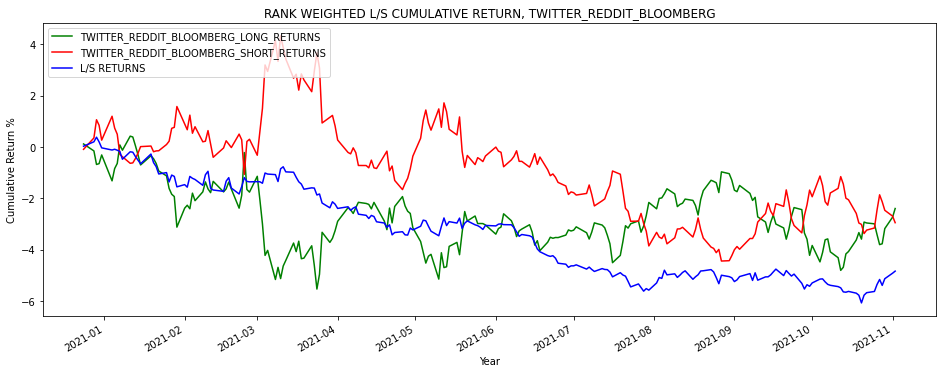

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS   -2.77%    7.59%           -2.4%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -3.41%    7.65%          -2.95%   
L/S RETURNS                             -5.58%    3.02%          -4.84%   

                                           MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS   -5.94%        -0.33         -0.46   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -8.42%        -0.42         -0.58   
L/S RETURNS                             -6.44%        -1.88          -2.5   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS         -0.47  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS         -0.4  
L/S RETURNS                                   -0.87

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 59.26 
 
 
 MSI 
 58.33 
 
 
 MA 
 57.41 
 
 
 AVGO 
 56.94 
 
 
 FISV 
 56.48 
 
 
 TXN 
 56.02 
 
 
 QCOM 
 56.02 
 
 
 TYL 
 55.56 
 
 
 QRVO 
 55.09 
 
 
 HPQ 
 54.63 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 KEYS 
 59.72 
 
 
 ADBE 
 59.26 
 
 
 ANSS 
 58.33 
 
 
 DXC 
 57.41 
 
 
 TRMB 
 56.02 
 
 
 INTU 
 56.02 
 
 
 ZBRA 
 55.56 
 
 
 PYPL 
 55.56 
 
 
 SNPS 
 55.09 
 
 
 CDAY 
 54.63

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


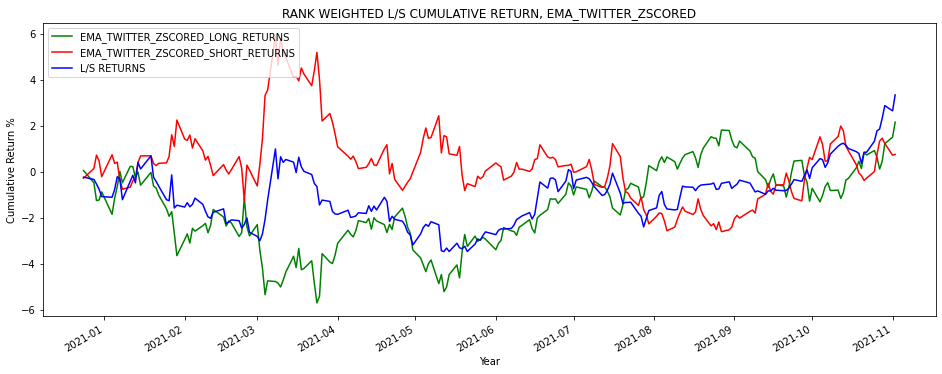

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS    2.5%    7.79%           2.15%  -5.92%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  0.87%    8.61%           0.75%  -8.03%   
L/S RETURNS                        3.87%    6.38%           3.34%  -4.41%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          0.36          0.51         0.42  
EMA_TWITTER_ZSCORED_SHORT_RETURNS         0.14          0.21         0.11  
L/S RETURNS                               0.63          0.94         0.88

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MPWR 
 63.89 
 
 
 IT 
 63.89 
 
 
 INTU 
 62.04 
 
 
 HPQ 
 60.19 
 
 
 PAYX 
 59.26 
 
 
 PAYC 
 59.26 
 
 
 MSI 
 59.26 
 
 
 CRM 
 57.87 
 
 
 ANET 
 57.41 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 WU 
 64.81 
 
 
 FISV 
 64.35 
 
 
 CTXS 
 63.89 
 
 
 FIS 
 62.50 
 
 
 GLW 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 GPN 
 59.72 
 
 
 VRSN 
 58.80 
 
 
 WDC 
 57.87 
 
 
 MU 
 57.87

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21


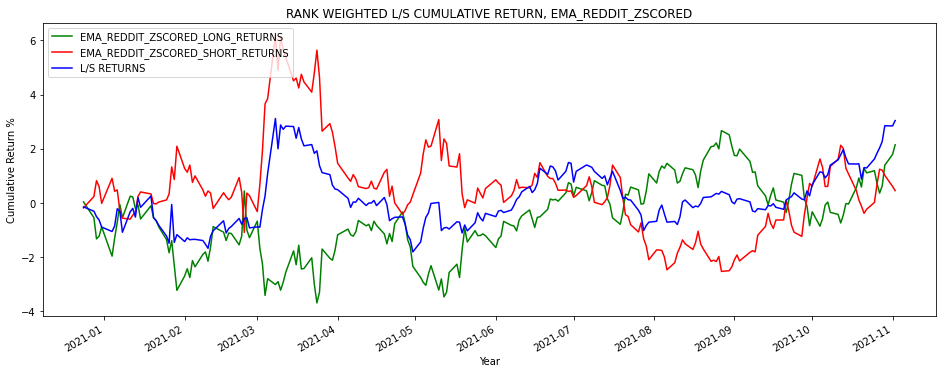

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS   2.49%    7.58%           2.15%  -4.11%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  0.53%    8.52%           0.45%  -8.19%   
L/S RETURNS                       3.53%    5.73%           3.04%  -4.77%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          0.36          0.52         0.61  
EMA_REDDIT_ZSCORED_SHORT_RETURNS          0.1          0.15         0.06  
L/S RETURNS                              0.63          0.96         0.74

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 68.98 
 
 
 MSI 
 66.20 
 
 
 TXN 
 62.04 
 
 
 MPWR 
 60.19 
 
 
 HPQ 
 59.26 
 
 
 AVGO 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 TRMB 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 TDY 
 57.41 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 GPN 
 68.52 
 
 
 CTXS 
 63.89 
 
 
 CSCO 
 62.96 
 
 
 IPGP 
 61.57 
 
 
 ADI 
 60.19 
 
 
 WDC 
 59.72 
 
 
 IBM 
 59.72 
 
 
 FIS 
 59.72 
 
 
 FLT 
 59.26 
 
 
 FISV 
 56.94

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


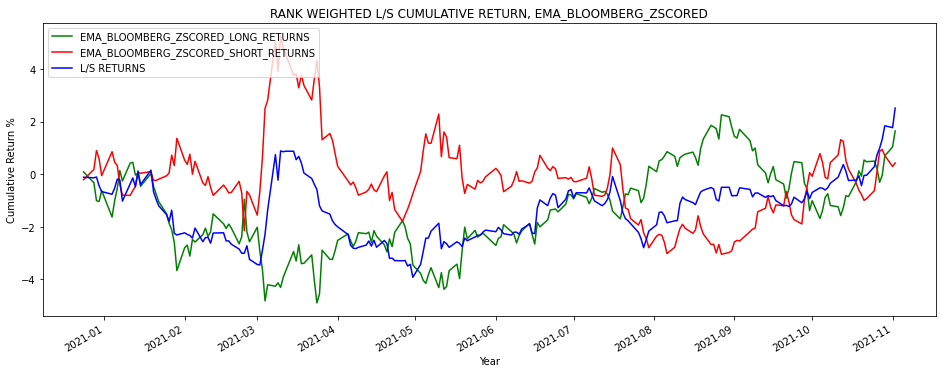

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS   1.91%    7.44%           1.65%  -5.33%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS   0.5%    8.67%           0.43%   -7.9%   
L/S RETURNS                          2.93%    5.65%           2.52%  -4.77%   

                                    Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          0.29          0.43         0.36  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS          0.1          0.15         0.06  
L/S RETURNS                                 0.54          0.85         0.61

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 66.20 
 
 
 IT 
 59.72 
 
 
 MPWR 
 58.33 
 
 
 NVDA 
 57.87 
 
 
 INTU 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 ZBRA 
 56.02 
 
 
 ANET 
 55.09 
 
 
 XLNX 
 54.63 
 
 
 KLAC 
 54.63 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 62.50 
 
 
 AKAM 
 59.26 
 
 
 GPN 
 57.87 
 
 
 CTSH 
 56.94 
 
 
 NLOK 
 56.94 
 
 
 VRSN 
 56.48 
 
 
 ANSS 
 55.09 
 
 
 HPQ 
 54.17 
 
 
 WU 
 54.17 
 
 
 TDY 
 53.70

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


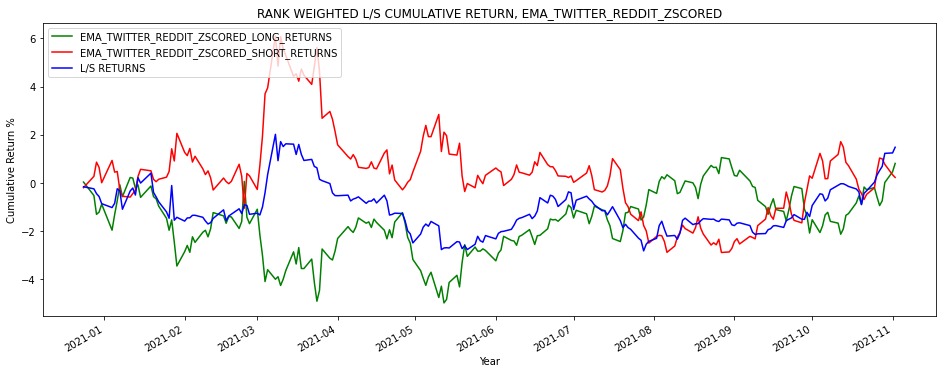

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   0.94%     7.7%           0.81%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  0.27%    8.37%           0.23%   
L/S RETURNS                               1.72%    5.32%           1.48%   

                                             MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   -5.19%         0.16          0.23   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -8.47%         0.07          0.11   
L/S RETURNS                               -4.74%         0.35          0.51   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          0.18  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS         0.03  
L/S RETURNS                                      0.36

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.83 
 
 
 MSI 
 65.28 
 
 
 HPQ 
 65.28 
 
 
 MPWR 
 61.57 
 
 
 ANET 
 59.26 
 
 
 AKAM 
 58.80 
 
 
 IT 
 56.94 
 
 
 INTU 
 56.94 
 
 
 TRMB 
 56.94 
 
 
 TXN 
 56.48 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 66.20 
 
 
 GPN 
 63.43 
 
 
 FISV 
 59.72 
 
 
 FIS 
 59.72 
 
 
 IPGP 
 58.80 
 
 
 WU 
 57.41 
 
 
 FLT 
 56.94 
 
 
 JNPR 
 56.94 
 
 
 WDC 
 56.94 
 
 
 PYPL 
 56.94

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21


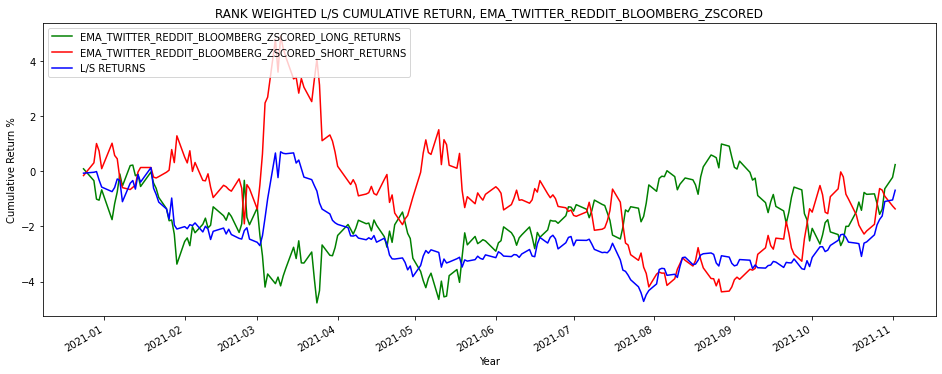

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS    0.28%    7.52%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -1.58%    8.32%   
L/S RETURNS                                          -0.8%    4.72%   

                                                   Cumulative Ret.     MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS            0.24%  -4.99%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS          -1.37%  -8.85%   
L/S RETURNS                                                 -0.69%  -5.39%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          0.07          0.11   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -0.15         -0.22   
L/S RETURNS                                               -0.15         -0.22   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          0.06  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -0.18  
L/S RETURNS                                               -0.15

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 71.76 
 
 
 MSI 
 58.80 
 
 
 MPWR 
 58.33 
 
 
 IT 
 57.87 
 
 
 TYL 
 56.02 
 
 
 ANET 
 56.02 
 
 
 AVGO 
 55.56 
 
 
 TXN 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 CDNS 
 54.63 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 65.74 
 
 
 ADBE 
 57.87 
 
 
 GPN 
 56.94 
 
 
 WU 
 56.48 
 
 
 FIS 
 56.48 
 
 
 WDC 
 55.56 
 
 
 KEYS 
 55.56 
 
 
 CTSH 
 54.63 
 
 
 IPGP 
 54.17 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22


In [17]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_rank(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                    
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('RANK WEIGHTED L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000 -0.137842   0.187529     0.040059      -0.024650   
REDDIT        -0.137842  1.000000  -0.129325     0.013011      -0.125474   
BLOOMBERG      0.187529 -0.129325   1.000000     0.259405      -0.152576   
EMA_ZSCORED    0.040059  0.013011   0.259405     1.000000      -0.191230   
EQUAL_RETURNS -0.024650 -0.125474  -0.152576    -0.191230       1.000000   
XLK_RETURNS    0.033611 -0.160360  -0.088466    -0.174889       0.884616   

               XLK_RETURNS  
TWITTER           0.033611  
REDDIT           -0.160360  
BLOOMBERG        -0.088466  
EMA_ZSCORED      -0.174889  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

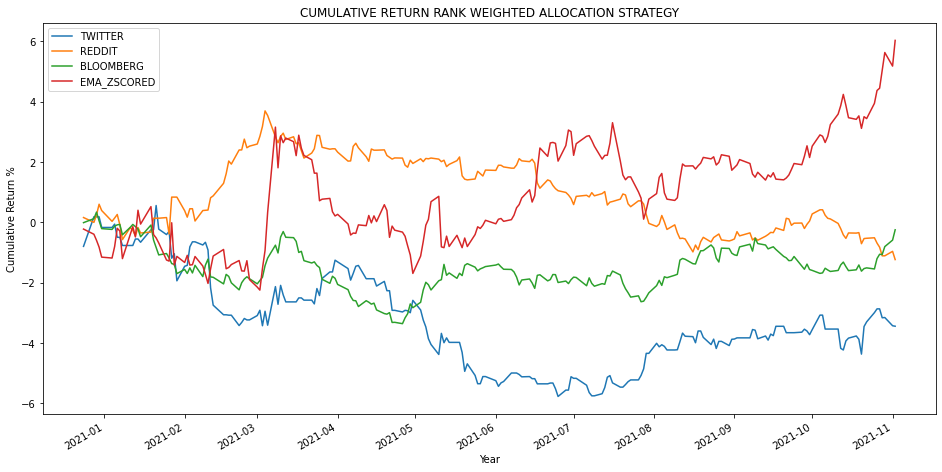

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -3.98%    4.98%          -3.45%  -6.29%        -0.79   
REDDIT       -1.43%     3.6%          -1.24%  -4.75%        -0.38   
BLOOMBERG    -0.29%     3.2%          -0.25%  -3.69%        -0.07   
EMA_ZSCORED   7.01%    7.37%           6.03%   -4.7%         0.96   

            Sortino Ratio Calmar Ratio  
TWITTER             -1.09        -0.63  
REDDIT              -0.55         -0.3  
BLOOMBERG           -0.11        -0.08  
EMA_ZSCORED          1.46         1.49

In [18]:
singles = zscore_returns[0:4]

singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))

TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.092067   
EMA_REDDIT_ZSCORED                                    0.168360   
EMA_BLOOMBERG_ZSCORED                                 0.272941   
EMA_TWITTER_REDDIT_ZSCORED                            0.232957   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.484951   
EQUAL_RETURNS                                        -0.025033   
XLK_RETURNS                                           0.014956   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.092067            0.168360   
EMA_TWITTER_ZSCORED                              1.000000            0.909942   
EMA_REDDIT_ZSCORED                               0.909942            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.894670            0.837958   
EMA_TWITTER_REDDIT_ZSCORED                       0.936419            0.972472   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.881319            0.881906   
EQUAL_RETURNS                                   -0.137447           -0.177805   
XLK_RETURNS                                     -0.119331           -0.181890   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.272941   
EMA_TWITTER_ZSCORED                                0.894670   
EMA_REDDIT_ZSCORED                                 0.837958   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.819898   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.935406   
EQUAL_RETURNS                                     -0.201886   
XLK_RETURNS                                       -0.164688   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.232957   
EMA_TWITTER_ZSCORED                                     0.936419   
EMA_REDDIT_ZSCORED                                      0.972472   
EMA_BLOOMBERG_ZSCORED                                   0.819898   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.901527   
EQUAL_RETURNS                                          -0.130334   
XLK_RETURNS                                            -0.131237   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.484951   
EMA_TWITTER_ZSCORED                                               0.881319   
EMA_REDDIT_ZSCORED                                                0.881906   
EMA_BLOOMBERG_ZSCORED                                             0.935406   
EMA_TWITTER_REDDIT_ZSCORED                                        0.901527   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.152891   
XLK_RETURNS                                                      -0.127530   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                  -0.025033     0.014956  
EMA_TWITTER_ZSCORED                       -0.137447    -0.119331  
EMA_REDDIT_ZSCORED                        -0.177805    -0.181890  
EMA_BLOOMBERG_ZSCORED                     -0.201886    -0.164688  
EMA_TWITTER_REDDIT_ZSCORED                -0.130334    -0.131237  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.152891    -0.127530  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

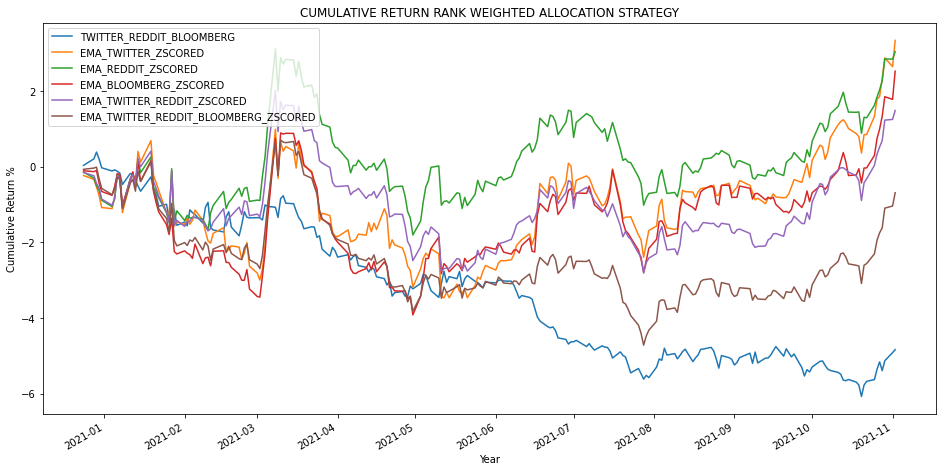

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -5.58%    3.02%          -4.84%  -6.44%   
EMA_TWITTER_ZSCORED                    3.87%    6.38%           3.34%  -4.41%   
EMA_REDDIT_ZSCORED                     3.53%    5.73%           3.04%  -4.77%   
EMA_BLOOMBERG_ZSCORED                  2.93%    5.65%           2.52%  -4.77%   
EMA_TWITTER_REDDIT_ZSCORED             1.72%    5.32%           1.48%  -4.74%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED   -0.8%    4.72%          -0.69%  -5.39%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -1.88          -2.5        -0.87  
EMA_TWITTER_ZSCORED                          0.63          0.94         0.88  
EMA_REDDIT_ZSCORED                           0.63          0.96         0.74  
EMA_BLOOMBERG_ZSCORED                        0.54          0.85         0.61  
EMA_TWITTER_REDDIT_ZSCORED                   0.35          0.51         0.36  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED        -0.15         -0.22        -0.15

In [19]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))

# OPEN TO OPEN

In [20]:
upper_q = 0.5
lower_q = 0.5
min_stocks_each_basket = 1
extra_weight = 0.2 # in min-max weighting due to min value is removed from the lowest value, 
                   #making the smallest value having zero weight which is a problem
                   # when the number of stocks in each basket is small.
        
returns_df = OPEN_TO_OPEN_STOCK_RETURNS.copy()

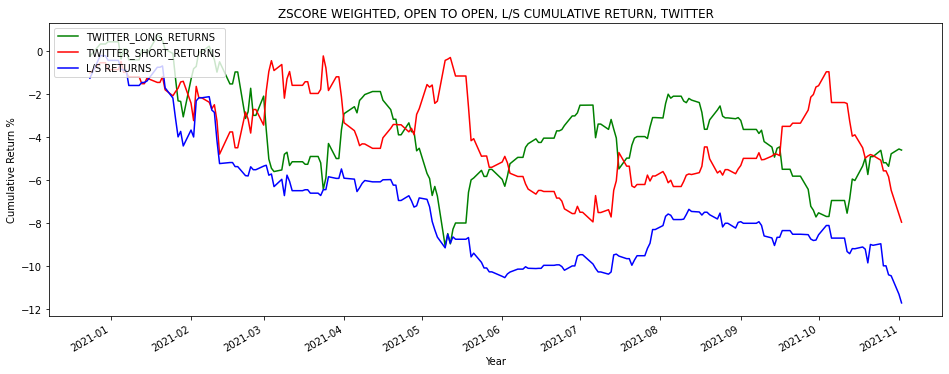

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS    -5.31%    9.16%           -4.6%   -9.71%        -0.55   
TWITTER_SHORT_RETURNS   -9.15%    9.02%          -7.96%   -7.96%        -1.02   
L/S RETURNS            -13.43%    6.23%         -11.72%  -11.72%        -2.28   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS          -0.71        -0.55  
TWITTER_SHORT_RETURNS         -1.44        -1.15  
L/S RETURNS                   -2.86        -1.15

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 38


TWITTER LONG % 
 
 
 
 
 CSCO 
 56.10 
 
 
 PAYC 
 54.88 
 
 
 ADSK 
 54.27 
 
 
 LRCX 
 52.44 
 
 
 QCOM 
 51.22 
 
 
 ADP 
 50.00 
 
 
 ORCL 
 49.39 
 
 
 CRM 
 48.78 
 
 
 ADI 
 48.78 
 
 
 MSFT 
 47.56 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 INTC 
 65.24 
 
 
 TER 
 58.54 
 
 
 PYPL 
 57.93 
 
 
 NVDA 
 57.32 
 
 
 AAPL 
 56.10 
 
 
 AMD 
 53.66 
 
 
 ADBE 
 51.22 
 
 
 MSFT 
 51.22 
 
 
 WDC 
 50.00 
 
 
 ADI 
 50.00

Mean Turnover, Long Basket, All days, TWITTER: 0.49
Mean Turnover, Short Basket, All days, TWITTER: 0.48
Mean Turnover, Long Basket, trading days only, TWITTER: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER: 0.21


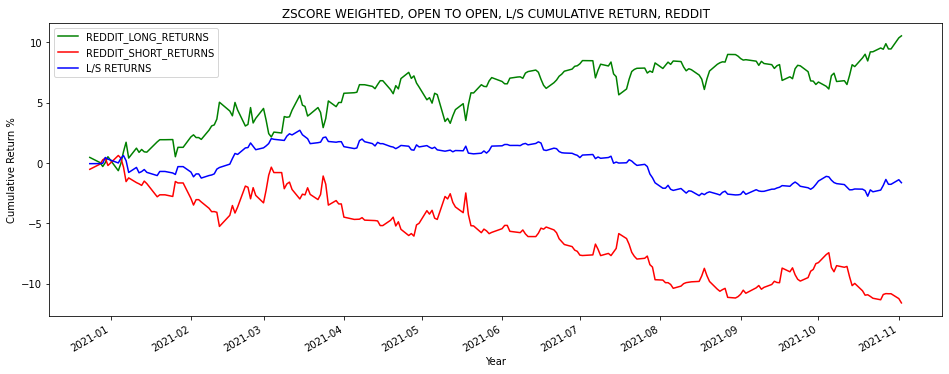

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS     12.3%    8.98%          10.55%   -3.93%         1.34   
REDDIT_SHORT_RETURNS  -13.29%    9.25%         -11.59%  -12.15%         -1.5   
L/S RETURNS            -1.88%    3.92%          -1.63%   -5.32%        -0.47   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS           1.91         3.13  
REDDIT_SHORT_RETURNS         -2.05        -1.09  
L/S RETURNS                  -0.64        -0.35

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 65


REDDIT LONG % 
 
 
 
 
 AVGO 
 58.45 
 
 
 HPQ 
 58.45 
 
 
 AKAM 
 57.97 
 
 
 TDY 
 57.49 
 
 
 APH 
 56.52 
 
 
 MSI 
 56.04 
 
 
 FTNT 
 55.07 
 
 
 ADBE 
 54.59 
 
 
 SWKS 
 54.11 
 
 
 ENPH 
 53.14 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 CSCO 
 61.35 
 
 
 SNPS 
 61.35 
 
 
 AAPL 
 59.90 
 
 
 ORCL 
 59.90 
 
 
 WDC 
 57.97 
 
 
 ADP 
 57.49 
 
 
 MSFT 
 57.00 
 
 
 IBM 
 56.52 
 
 
 HPE 
 56.04 
 
 
 AMD 
 55.07

Mean Turnover, Long Basket, All days, REDDIT: 0.26
Mean Turnover, Short Basket, All days, REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, REDDIT: 0.2
Mean Turnover, Short Basket, trading days only, REDDIT: 0.21


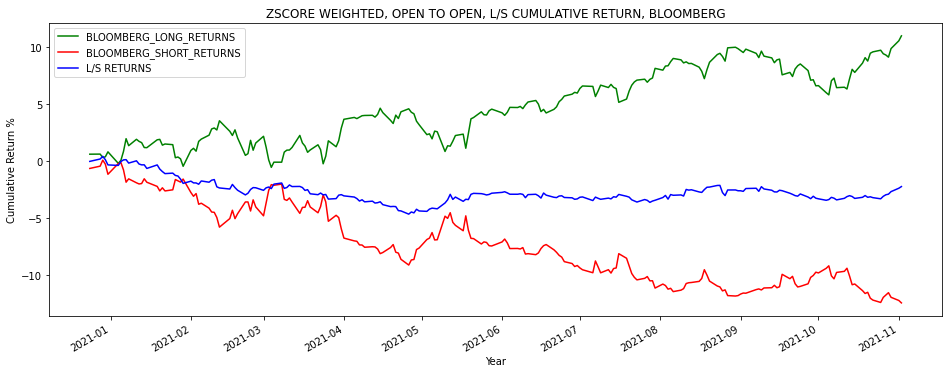

CAGR Ann. Vol Cumulative Ret.      MDD  \
BLOOMBERG_LONG_RETURNS    12.86%    8.49%          11.02%   -3.95%   
BLOOMBERG_SHORT_RETURNS  -14.27%    8.71%         -12.45%  -12.54%   
L/S RETURNS               -2.57%    3.42%          -2.23%   -5.06%   

                        Sharpe Ratio Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS          1.47          2.17         3.25  
BLOOMBERG_SHORT_RETURNS        -1.72         -2.34        -1.14  
L/S RETURNS                    -0.75         -1.03        -0.51

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 NVDA 
 57.87 
 
 
 V 
 57.41 
 
 
 FISV 
 57.41 
 
 
 MA 
 57.41 
 
 
 INTC 
 56.48 
 
 
 QCOM 
 54.63 
 
 
 FTNT 
 54.63 
 
 
 AMD 
 54.17 
 
 
 TXN 
 54.17 
 
 
 ORCL 
 54.17 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 59.72 
 
 
 KEYS 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 DXC 
 56.48 
 
 
 QRVO 
 56.02 
 
 
 CDW 
 55.56 
 
 
 JKHY 
 55.56 
 
 
 PTC 
 55.09 
 
 
 NTAP 
 54.63 
 
 
 PAYC 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.2
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


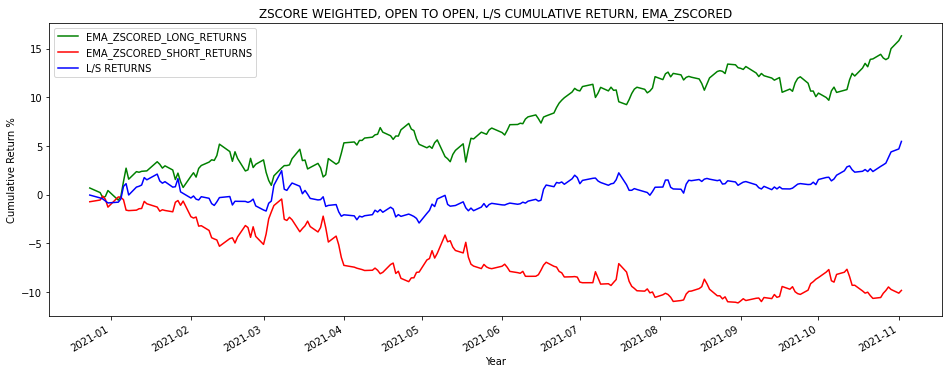

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_ZSCORED_LONG_RETURNS    19.11%    9.16%          16.31%   -4.02%   
EMA_ZSCORED_SHORT_RETURNS  -11.29%     9.8%          -9.83%  -11.12%   
L/S RETURNS                  6.36%    7.08%           5.47%   -5.24%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          1.96          2.93         4.76  
EMA_ZSCORED_SHORT_RETURNS        -1.17         -1.58        -1.02  
L/S RETURNS                       0.91          1.32         1.21

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


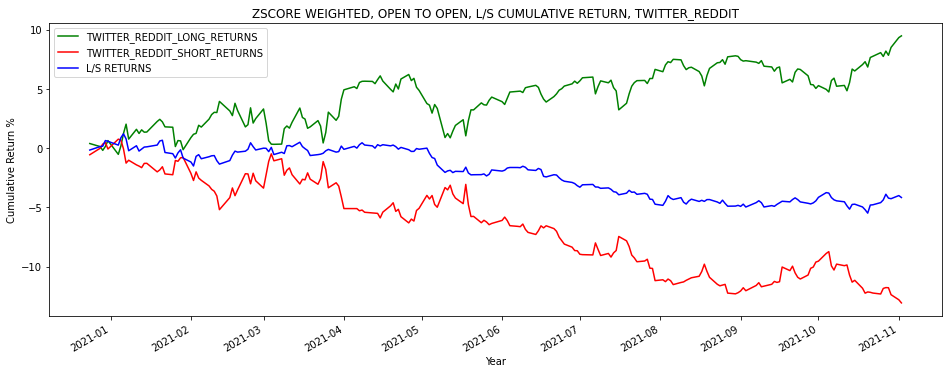

CAGR Ann. Vol Cumulative Ret.      MDD  \
TWITTER_REDDIT_LONG_RETURNS    11.06%    9.54%           9.48%   -5.03%   
TWITTER_REDDIT_SHORT_RETURNS  -14.95%    9.23%         -13.05%  -13.71%   
L/S RETURNS                     -4.8%    4.41%          -4.16%   -6.61%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS          1.15          1.61          2.2  
TWITTER_REDDIT_SHORT_RETURNS        -1.71          -2.3        -1.09  
L/S RETURNS                         -1.09         -1.46        -0.73

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 69


TWITTER_REDDIT LONG % 
 
 
 
 
 HPQ 
 63.43 
 
 
 AKAM 
 57.41 
 
 
 CRM 
 55.09 
 
 
 FTNT 
 55.09 
 
 
 SWKS 
 53.70 
 
 
 QCOM 
 52.31 
 
 
 TER 
 52.31 
 
 
 MSI 
 50.93 
 
 
 BR 
 50.46 
 
 
 NTAP 
 49.54 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 SNPS 
 59.72 
 
 
 HPE 
 57.41 
 
 
 ADBE 
 55.56 
 
 
 AAPL 
 55.09 
 
 
 PYPL 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 AMD 
 54.17 
 
 
 NVDA 
 54.17 
 
 
 INTU 
 54.17 
 
 
 GLW 
 53.70

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.26


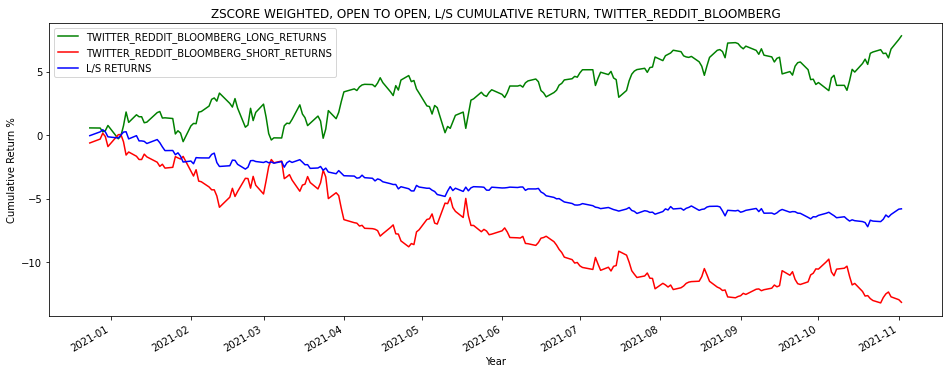

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS     9.12%     8.8%           7.83%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -15.08%    8.57%         -13.17%   
L/S RETURNS                              -6.68%    3.36%           -5.8%   

                                            MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS     -4.3%         1.04          1.47   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -13.36%        -1.86         -2.49   
L/S RETURNS                              -7.61%        -2.04         -2.67   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS          2.12  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -1.13  
L/S RETURNS                                   -0.88

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 59.26 
 
 
 MSI 
 58.33 
 
 
 MA 
 57.41 
 
 
 AVGO 
 56.94 
 
 
 FISV 
 56.48 
 
 
 TXN 
 56.02 
 
 
 QCOM 
 56.02 
 
 
 TYL 
 55.56 
 
 
 QRVO 
 55.09 
 
 
 HPQ 
 54.63 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 KEYS 
 59.72 
 
 
 ADBE 
 59.26 
 
 
 ANSS 
 58.33 
 
 
 DXC 
 57.41 
 
 
 TRMB 
 56.02 
 
 
 INTU 
 56.02 
 
 
 ZBRA 
 55.56 
 
 
 PYPL 
 55.56 
 
 
 SNPS 
 55.09 
 
 
 CDAY 
 54.63

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


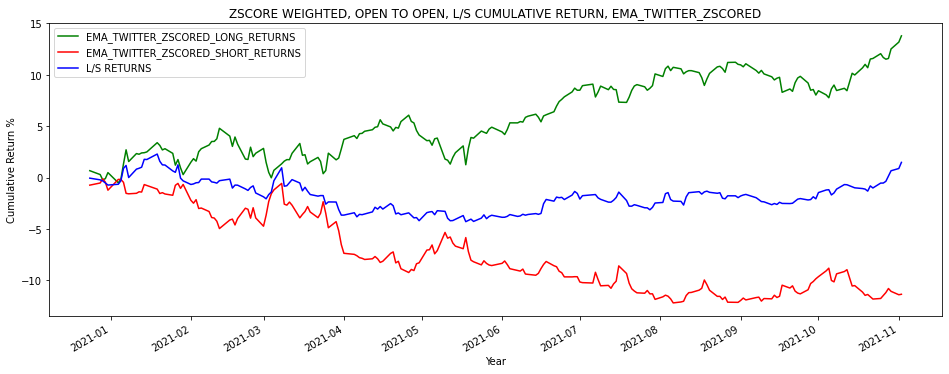

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS    16.13%    9.29%           13.8%   -4.59%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  -13.01%    9.45%         -11.34%  -12.18%   
L/S RETURNS                          1.72%     6.3%           1.49%   -6.43%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          1.66          2.42         3.51  
EMA_TWITTER_ZSCORED_SHORT_RETURNS        -1.43          -1.9        -1.07  
L/S RETURNS                                0.3          0.42         0.27

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MPWR 
 63.89 
 
 
 IT 
 63.89 
 
 
 INTU 
 62.04 
 
 
 HPQ 
 60.19 
 
 
 PAYX 
 59.26 
 
 
 PAYC 
 59.26 
 
 
 MSI 
 59.26 
 
 
 CRM 
 57.87 
 
 
 ANET 
 57.41 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 WU 
 64.81 
 
 
 FISV 
 64.35 
 
 
 CTXS 
 63.89 
 
 
 FIS 
 62.50 
 
 
 GLW 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 GPN 
 59.72 
 
 
 VRSN 
 58.80 
 
 
 WDC 
 57.87 
 
 
 MU 
 57.87

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21


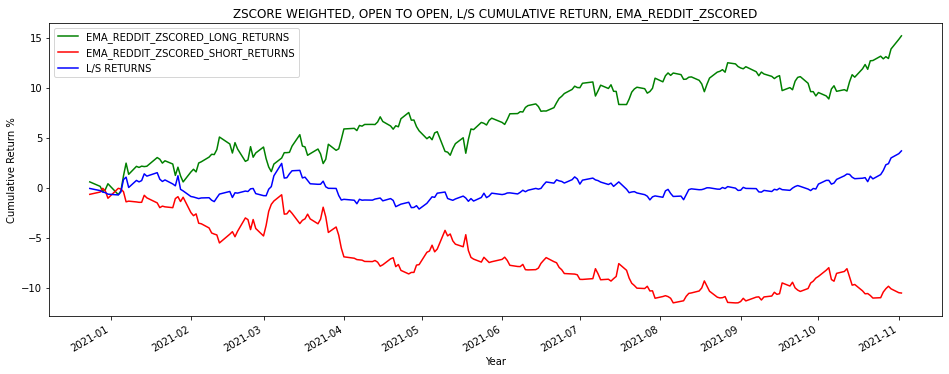

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS    17.78%     9.1%          15.19%   -3.97%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  -12.08%    9.35%         -10.52%  -11.51%   
L/S RETURNS                         4.28%    5.67%           3.69%   -4.46%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          1.85          2.74         4.48  
EMA_REDDIT_ZSCORED_SHORT_RETURNS        -1.33         -1.78        -1.05  
L/S RETURNS                              0.77          1.11         0.96

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 68.98 
 
 
 MSI 
 66.20 
 
 
 TXN 
 62.04 
 
 
 MPWR 
 60.19 
 
 
 HPQ 
 59.26 
 
 
 AVGO 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 TRMB 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 TDY 
 57.41 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 GPN 
 68.52 
 
 
 CTXS 
 63.89 
 
 
 CSCO 
 62.96 
 
 
 IPGP 
 61.57 
 
 
 ADI 
 60.19 
 
 
 WDC 
 59.72 
 
 
 IBM 
 59.72 
 
 
 FIS 
 59.72 
 
 
 FLT 
 59.26 
 
 
 FISV 
 56.94

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


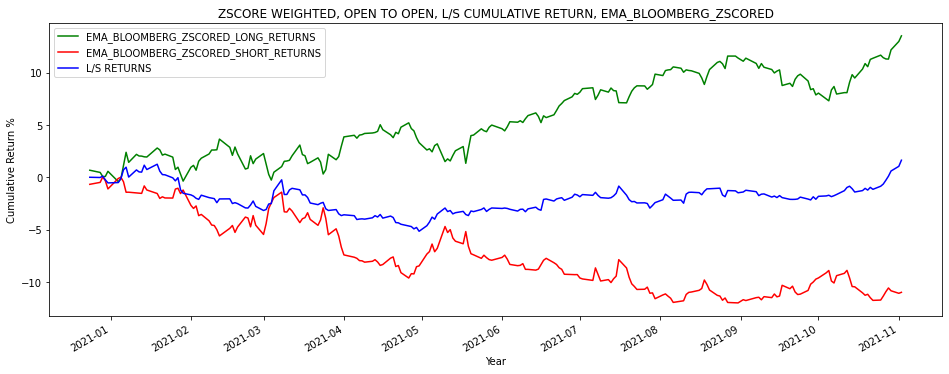

CAGR Ann. Vol Cumulative Ret.  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS     15.8%    8.76%          13.52%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -12.61%     9.4%         -10.99%   
L/S RETURNS                            1.89%    5.51%           1.63%   

                                         MDD Sharpe Ratio Sortino Ratio  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    -3.83%         1.72          2.56   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -12.03%        -1.39         -1.88   
L/S RETURNS                           -6.33%         0.37          0.54   

                                    Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          4.12  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.05  
L/S RETURNS                                  0.3

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 66.20 
 
 
 IT 
 59.72 
 
 
 MPWR 
 58.33 
 
 
 NVDA 
 57.87 
 
 
 INTU 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 ZBRA 
 56.02 
 
 
 ANET 
 55.09 
 
 
 XLNX 
 54.63 
 
 
 KLAC 
 54.63 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 62.50 
 
 
 AKAM 
 59.26 
 
 
 GPN 
 57.87 
 
 
 CTSH 
 56.94 
 
 
 NLOK 
 56.94 
 
 
 VRSN 
 56.48 
 
 
 ANSS 
 55.09 
 
 
 HPQ 
 54.17 
 
 
 WU 
 54.17 
 
 
 TDY 
 53.70

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


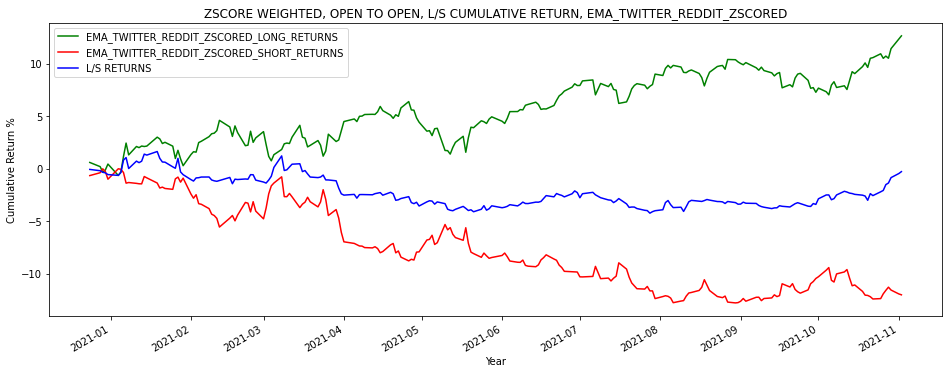

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    14.76%    9.13%          12.63%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -13.77%    9.22%         -12.01%   
L/S RETURNS                                -0.33%    5.28%          -0.29%   

                                              MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS     -4.7%         1.55          2.26   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -12.78%        -1.56         -2.07   
L/S RETURNS                                -5.77%        -0.04         -0.05   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          3.14  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS        -1.08  
L/S RETURNS                                     -0.06

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.83 
 
 
 MSI 
 65.28 
 
 
 HPQ 
 65.28 
 
 
 MPWR 
 61.57 
 
 
 ANET 
 59.26 
 
 
 AKAM 
 58.80 
 
 
 IT 
 56.94 
 
 
 INTU 
 56.94 
 
 
 TRMB 
 56.94 
 
 
 TXN 
 56.48 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 66.20 
 
 
 GPN 
 63.43 
 
 
 FISV 
 59.72 
 
 
 FIS 
 59.72 
 
 
 IPGP 
 58.80 
 
 
 WU 
 57.41 
 
 
 FLT 
 56.94 
 
 
 JNPR 
 56.94 
 
 
 WDC 
 56.94 
 
 
 PYPL 
 56.94

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21


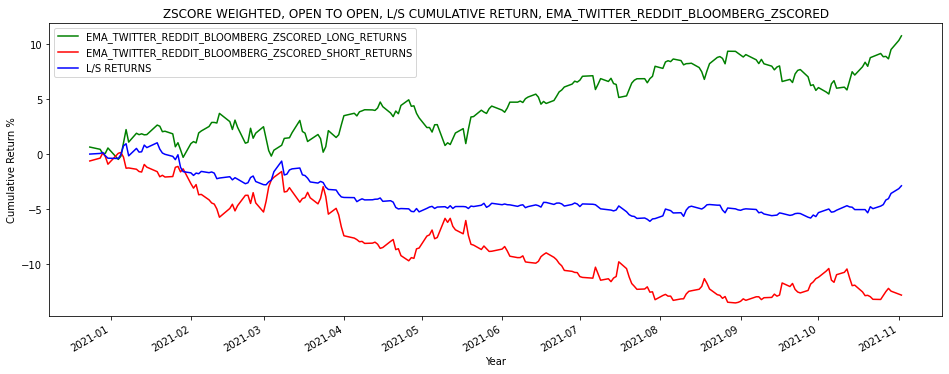

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS   12.53%    8.85%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -14.7%    9.01%   
L/S RETURNS                                         -3.34%    4.66%   

                                                   Cumulative Ret.      MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS           10.74%   -3.96%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         -12.83%  -13.66%   
L/S RETURNS                                                 -2.89%   -7.07%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          1.38           2.0   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.72         -2.28   
L/S RETURNS                                               -0.71         -0.95   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          3.17  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.08  
L/S RETURNS                                               -0.47

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 71.76 
 
 
 MSI 
 58.80 
 
 
 MPWR 
 58.33 
 
 
 IT 
 57.87 
 
 
 TYL 
 56.02 
 
 
 ANET 
 56.02 
 
 
 AVGO 
 55.56 
 
 
 TXN 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 CDNS 
 54.63 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 65.74 
 
 
 ADBE 
 57.87 
 
 
 GPN 
 56.94 
 
 
 WU 
 56.48 
 
 
 FIS 
 56.48 
 
 
 WDC 
 55.56 
 
 
 KEYS 
 55.56 
 
 
 CTSH 
 54.63 
 
 
 IPGP 
 54.17 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22


In [21]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_minmax(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                     extra_weight           = extra_weight
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('ZSCORE WEIGHTED, OPEN TO OPEN, L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000 -0.018792   0.091075    -0.078327       0.068308   
REDDIT        -0.018792  1.000000  -0.050656     0.059269      -0.135642   
BLOOMBERG      0.091075 -0.050656   1.000000     0.208331      -0.023768   
EMA_ZSCORED   -0.078327  0.059269   0.208331     1.000000      -0.104493   
EQUAL_RETURNS  0.068308 -0.135642  -0.023768    -0.104493       1.000000   
XLK_RETURNS    0.096591 -0.139541   0.027726    -0.081439       0.884616   

               XLK_RETURNS  
TWITTER           0.096591  
REDDIT           -0.139541  
BLOOMBERG         0.027726  
EMA_ZSCORED      -0.081439  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

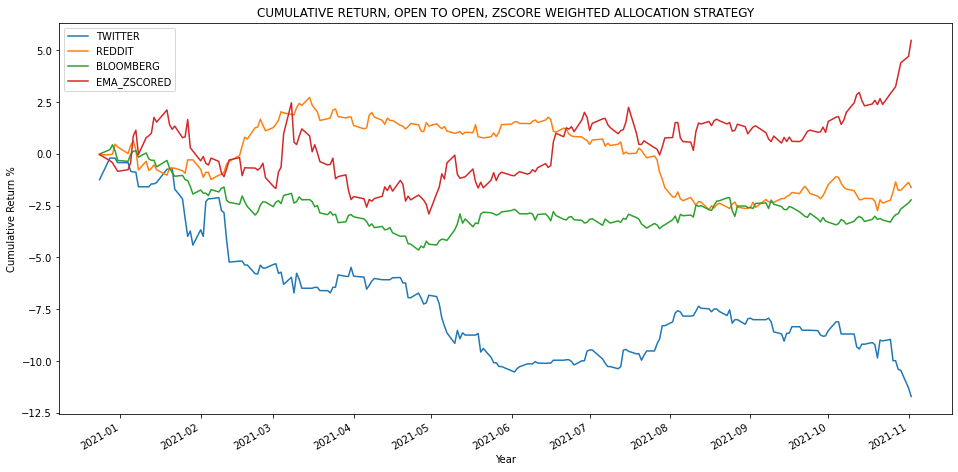

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
TWITTER      -13.43%    6.23%         -11.72%  -11.72%        -2.28   
REDDIT        -1.88%    3.92%          -1.63%   -5.32%        -0.47   
BLOOMBERG     -2.57%    3.42%          -2.23%   -5.06%        -0.75   
EMA_ZSCORED    6.36%    7.08%           5.47%   -5.24%         0.91   

            Sortino Ratio Calmar Ratio  
TWITTER             -2.86        -1.15  
REDDIT              -0.64        -0.35  
BLOOMBERG           -1.03        -0.51  
EMA_ZSCORED          1.32         1.21

In [22]:
singles = zscore_returns[0:4]
singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN, OPEN TO OPEN, ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))

TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.141489   
EMA_REDDIT_ZSCORED                                    0.207613   
EMA_BLOOMBERG_ZSCORED                                 0.310908   
EMA_TWITTER_REDDIT_ZSCORED                            0.315396   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.569471   
EQUAL_RETURNS                                         0.035427   
XLK_RETURNS                                           0.058245   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.141489            0.207613   
EMA_TWITTER_ZSCORED                              1.000000            0.885811   
EMA_REDDIT_ZSCORED                               0.885811            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.870627            0.813168   
EMA_TWITTER_REDDIT_ZSCORED                       0.913401            0.959528   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.854495            0.852213   
EQUAL_RETURNS                                   -0.035165           -0.101578   
XLK_RETURNS                                     -0.015158           -0.095496   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.310908   
EMA_TWITTER_ZSCORED                                0.870627   
EMA_REDDIT_ZSCORED                                 0.813168   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.781087   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.905106   
EQUAL_RETURNS                                     -0.090715   
XLK_RETURNS                                       -0.048110   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.315396   
EMA_TWITTER_ZSCORED                                     0.913401   
EMA_REDDIT_ZSCORED                                      0.959528   
EMA_BLOOMBERG_ZSCORED                                   0.781087   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.889301   
EQUAL_RETURNS                                          -0.060767   
XLK_RETURNS                                            -0.054917   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.569471   
EMA_TWITTER_ZSCORED                                               0.854495   
EMA_REDDIT_ZSCORED                                                0.852213   
EMA_BLOOMBERG_ZSCORED                                             0.905106   
EMA_TWITTER_REDDIT_ZSCORED                                        0.889301   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.046491   
XLK_RETURNS                                                      -0.017870   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                   0.035427     0.058245  
EMA_TWITTER_ZSCORED                       -0.035165    -0.015158  
EMA_REDDIT_ZSCORED                        -0.101578    -0.095496  
EMA_BLOOMBERG_ZSCORED                     -0.090715    -0.048110  
EMA_TWITTER_REDDIT_ZSCORED                -0.060767    -0.054917  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.046491    -0.017870  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

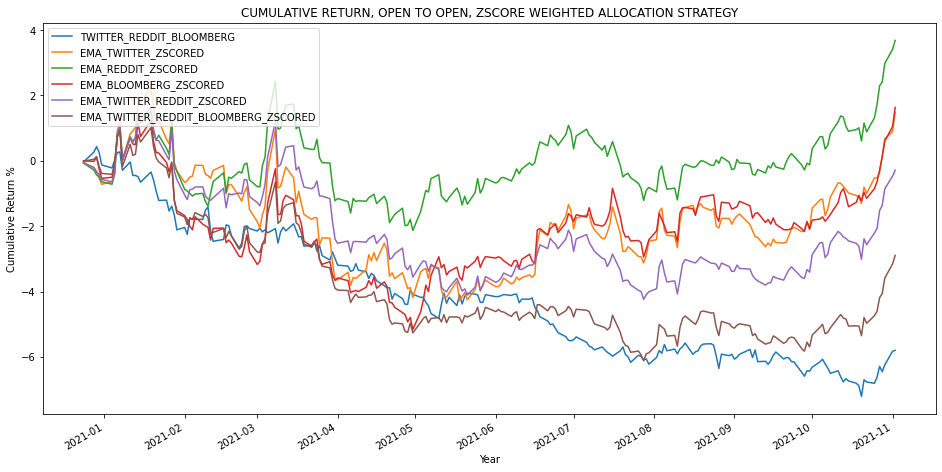

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -6.68%    3.36%           -5.8%  -7.61%   
EMA_TWITTER_ZSCORED                    1.72%     6.3%           1.49%  -6.43%   
EMA_REDDIT_ZSCORED                     4.28%    5.67%           3.69%  -4.46%   
EMA_BLOOMBERG_ZSCORED                  1.89%    5.51%           1.63%  -6.33%   
EMA_TWITTER_REDDIT_ZSCORED            -0.33%    5.28%          -0.29%  -5.77%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  -3.34%    4.66%          -2.89%  -7.07%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -2.04         -2.67        -0.88  
EMA_TWITTER_ZSCORED                           0.3          0.42         0.27  
EMA_REDDIT_ZSCORED                           0.77          1.11         0.96  
EMA_BLOOMBERG_ZSCORED                        0.37          0.54          0.3  
EMA_TWITTER_REDDIT_ZSCORED                  -0.04         -0.05        -0.06  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED        -0.71         -0.95        -0.47

In [23]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN, OPEN TO OPEN, ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))

# RANK WEIGHTED

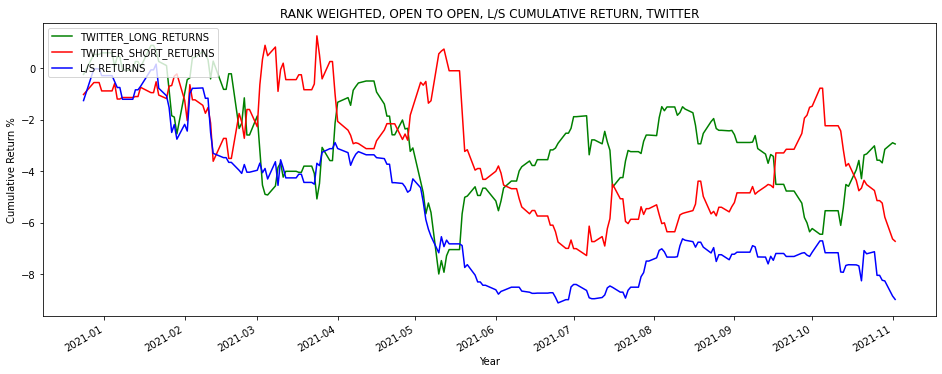

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS     -3.4%    8.88%          -2.94%  -8.82%        -0.34   
TWITTER_SHORT_RETURNS   -7.75%    8.89%          -6.73%  -8.44%        -0.86   
L/S RETURNS            -10.33%    5.88%          -8.99%  -9.28%        -1.82   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS          -0.45        -0.39  
TWITTER_SHORT_RETURNS         -1.22        -0.92  
L/S RETURNS                   -2.39        -1.11

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 38


TWITTER LONG % 
 
 
 
 
 CSCO 
 56.10 
 
 
 PAYC 
 54.88 
 
 
 ADSK 
 54.27 
 
 
 LRCX 
 52.44 
 
 
 QCOM 
 51.22 
 
 
 ADP 
 50.00 
 
 
 ORCL 
 49.39 
 
 
 CRM 
 48.78 
 
 
 ADI 
 48.78 
 
 
 MSFT 
 47.56 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 INTC 
 65.24 
 
 
 TER 
 58.54 
 
 
 PYPL 
 57.93 
 
 
 NVDA 
 57.32 
 
 
 AAPL 
 56.10 
 
 
 AMD 
 53.66 
 
 
 ADBE 
 51.22 
 
 
 MSFT 
 51.22 
 
 
 WDC 
 50.00 
 
 
 ADI 
 50.00

Mean Turnover, Long Basket, All days, TWITTER: 0.49
Mean Turnover, Short Basket, All days, TWITTER: 0.48
Mean Turnover, Long Basket, trading days only, TWITTER: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER: 0.21


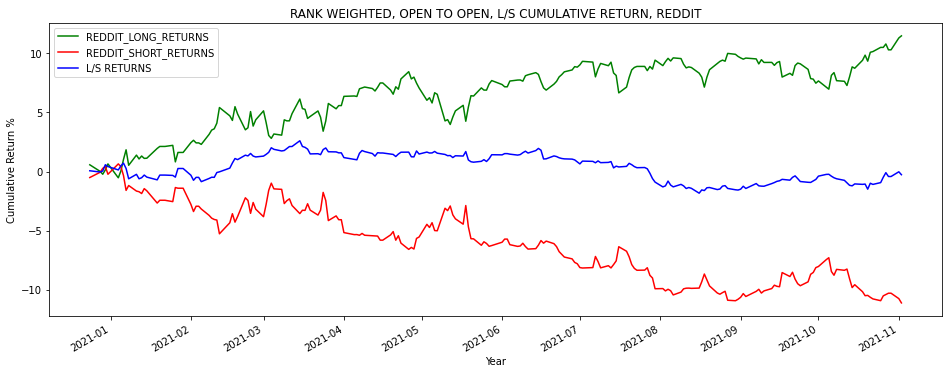

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS     13.4%     8.9%          11.48%   -4.12%         1.46   
REDDIT_SHORT_RETURNS  -12.74%    9.17%         -11.11%  -11.68%        -1.44   
L/S RETURNS            -0.31%    3.86%          -0.27%   -4.32%        -0.06   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS            2.1         3.25  
REDDIT_SHORT_RETURNS         -1.97        -1.09  
L/S RETURNS                  -0.09        -0.07

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 65


REDDIT LONG % 
 
 
 
 
 AVGO 
 58.45 
 
 
 HPQ 
 58.45 
 
 
 AKAM 
 57.97 
 
 
 TDY 
 57.49 
 
 
 APH 
 56.52 
 
 
 MSI 
 56.04 
 
 
 FTNT 
 55.07 
 
 
 ADBE 
 54.59 
 
 
 SWKS 
 54.11 
 
 
 ENPH 
 53.14 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 CSCO 
 61.35 
 
 
 SNPS 
 61.35 
 
 
 AAPL 
 59.90 
 
 
 ORCL 
 59.90 
 
 
 WDC 
 57.97 
 
 
 ADP 
 57.49 
 
 
 MSFT 
 57.00 
 
 
 IBM 
 56.52 
 
 
 HPE 
 56.04 
 
 
 AMD 
 55.07

Mean Turnover, Long Basket, All days, REDDIT: 0.26
Mean Turnover, Short Basket, All days, REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, REDDIT: 0.2
Mean Turnover, Short Basket, trading days only, REDDIT: 0.21


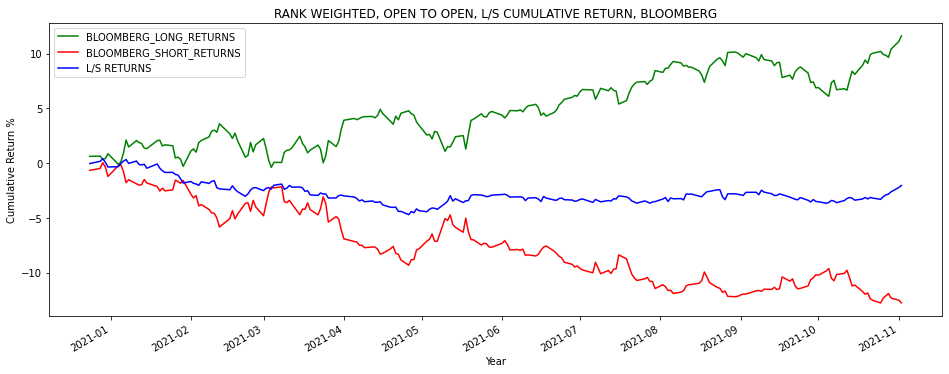

CAGR Ann. Vol Cumulative Ret.      MDD  \
BLOOMBERG_LONG_RETURNS    13.59%    8.49%          11.63%   -3.85%   
BLOOMBERG_SHORT_RETURNS  -14.62%     8.7%         -12.77%  -12.81%   
L/S RETURNS               -2.36%    3.53%          -2.04%   -5.09%   

                        Sharpe Ratio Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS          1.54           2.3         3.52  
BLOOMBERG_SHORT_RETURNS        -1.77          -2.4        -1.14  
L/S RETURNS                    -0.66         -0.91        -0.46

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 NVDA 
 57.87 
 
 
 V 
 57.41 
 
 
 FISV 
 57.41 
 
 
 MA 
 57.41 
 
 
 INTC 
 56.48 
 
 
 QCOM 
 54.63 
 
 
 FTNT 
 54.63 
 
 
 AMD 
 54.17 
 
 
 TXN 
 54.17 
 
 
 ORCL 
 54.17 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 59.72 
 
 
 KEYS 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 DXC 
 56.48 
 
 
 QRVO 
 56.02 
 
 
 CDW 
 55.56 
 
 
 JKHY 
 55.56 
 
 
 PTC 
 55.09 
 
 
 NTAP 
 54.63 
 
 
 PAYC 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.2
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


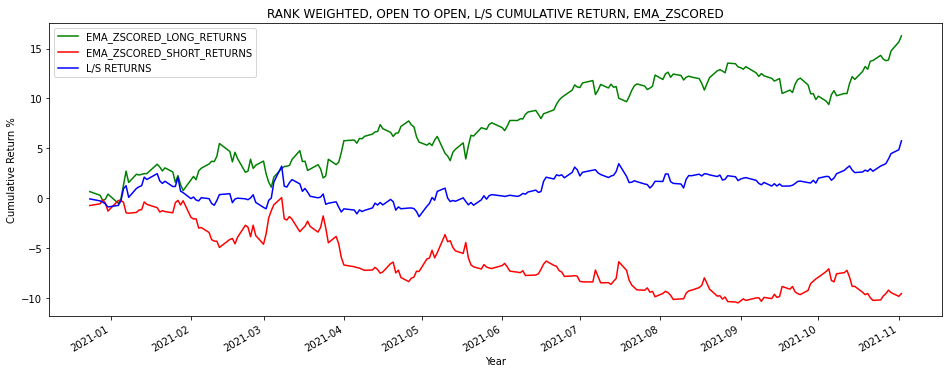

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_ZSCORED_LONG_RETURNS    19.07%     9.1%          16.28%   -4.16%   
EMA_ZSCORED_SHORT_RETURNS  -10.98%    9.82%          -9.56%  -10.55%   
L/S RETURNS                  6.68%    7.23%           5.75%   -4.91%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          1.96          2.96         4.59  
EMA_ZSCORED_SHORT_RETURNS        -1.13         -1.53        -1.04  
L/S RETURNS                       0.93          1.36         1.36

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


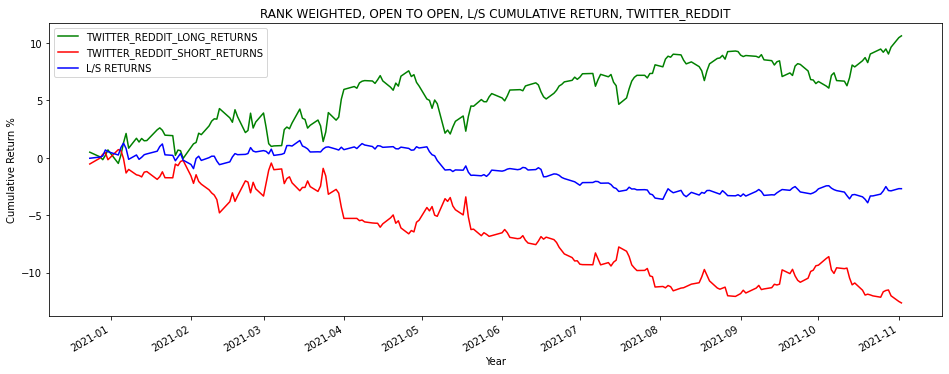

CAGR Ann. Vol Cumulative Ret.      MDD  \
TWITTER_REDDIT_LONG_RETURNS    12.39%    9.52%          10.62%   -5.11%   
TWITTER_REDDIT_SHORT_RETURNS  -14.46%    9.19%         -12.62%  -13.24%   
L/S RETURNS                     -3.1%    4.28%          -2.68%   -5.34%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS          1.28          1.81         2.43  
TWITTER_REDDIT_SHORT_RETURNS        -1.65         -2.22        -1.09  
L/S RETURNS                         -0.71         -0.97        -0.58

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 69


TWITTER_REDDIT LONG % 
 
 
 
 
 HPQ 
 63.43 
 
 
 AKAM 
 57.41 
 
 
 CRM 
 55.09 
 
 
 FTNT 
 55.09 
 
 
 SWKS 
 53.70 
 
 
 QCOM 
 52.31 
 
 
 TER 
 52.31 
 
 
 MSI 
 50.93 
 
 
 BR 
 50.46 
 
 
 NTAP 
 49.54 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 SNPS 
 59.72 
 
 
 HPE 
 57.41 
 
 
 ADBE 
 55.56 
 
 
 AAPL 
 55.09 
 
 
 PYPL 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 AMD 
 54.17 
 
 
 NVDA 
 54.17 
 
 
 INTU 
 54.17 
 
 
 GLW 
 53.70

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.26
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.26
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.26


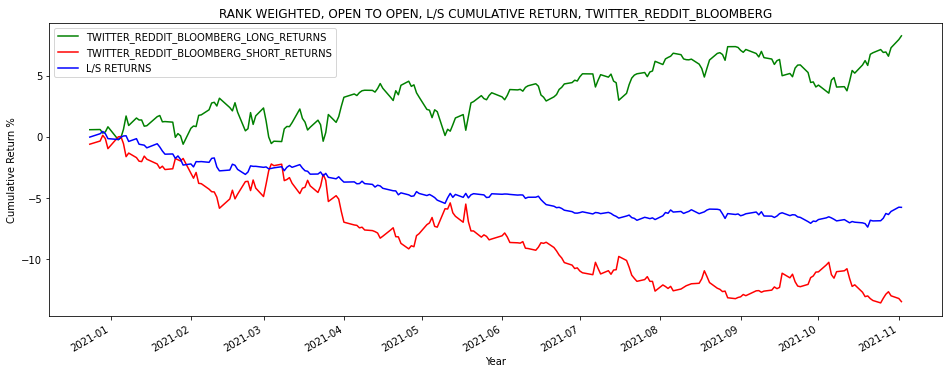

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS     9.59%    8.78%           8.23%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -15.39%    8.51%         -13.45%   
L/S RETURNS                              -6.63%    3.39%          -5.75%   

                                            MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS    -4.23%         1.09          1.54   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -13.66%        -1.92         -2.54   
L/S RETURNS                              -7.77%        -2.01         -2.63   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS          2.27  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -1.13  
L/S RETURNS                                   -0.85

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 59.26 
 
 
 MSI 
 58.33 
 
 
 MA 
 57.41 
 
 
 AVGO 
 56.94 
 
 
 FISV 
 56.48 
 
 
 TXN 
 56.02 
 
 
 QCOM 
 56.02 
 
 
 TYL 
 55.56 
 
 
 QRVO 
 55.09 
 
 
 HPQ 
 54.63 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 KEYS 
 59.72 
 
 
 ADBE 
 59.26 
 
 
 ANSS 
 58.33 
 
 
 DXC 
 57.41 
 
 
 TRMB 
 56.02 
 
 
 INTU 
 56.02 
 
 
 ZBRA 
 55.56 
 
 
 PYPL 
 55.56 
 
 
 SNPS 
 55.09 
 
 
 CDAY 
 54.63

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.22
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


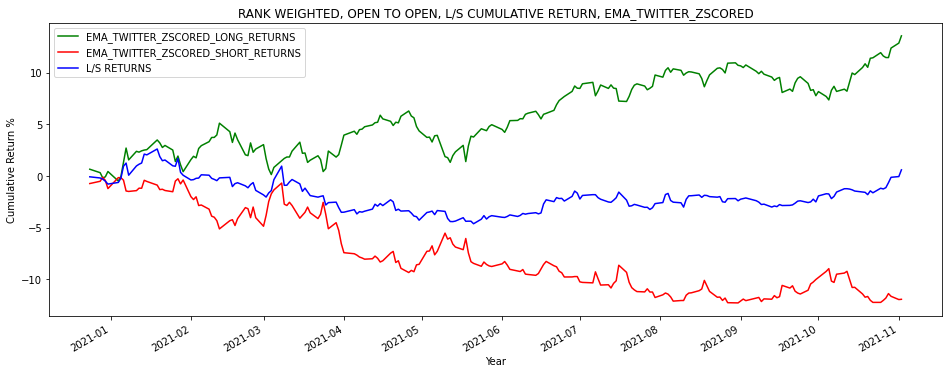

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS    15.86%    9.18%          13.57%   -4.74%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  -13.69%    9.53%         -11.94%  -12.29%   
L/S RETURNS                          0.68%    6.33%           0.59%   -7.05%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          1.65          2.41         3.35  
EMA_TWITTER_ZSCORED_SHORT_RETURNS         -1.5         -1.99        -1.11  
L/S RETURNS                               0.14          0.19          0.1

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MPWR 
 63.89 
 
 
 IT 
 63.89 
 
 
 INTU 
 62.04 
 
 
 HPQ 
 60.19 
 
 
 PAYX 
 59.26 
 
 
 PAYC 
 59.26 
 
 
 MSI 
 59.26 
 
 
 CRM 
 57.87 
 
 
 ANET 
 57.41 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 WU 
 64.81 
 
 
 FISV 
 64.35 
 
 
 CTXS 
 63.89 
 
 
 FIS 
 62.50 
 
 
 GLW 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 GPN 
 59.72 
 
 
 VRSN 
 58.80 
 
 
 WDC 
 57.87 
 
 
 MU 
 57.87

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.21


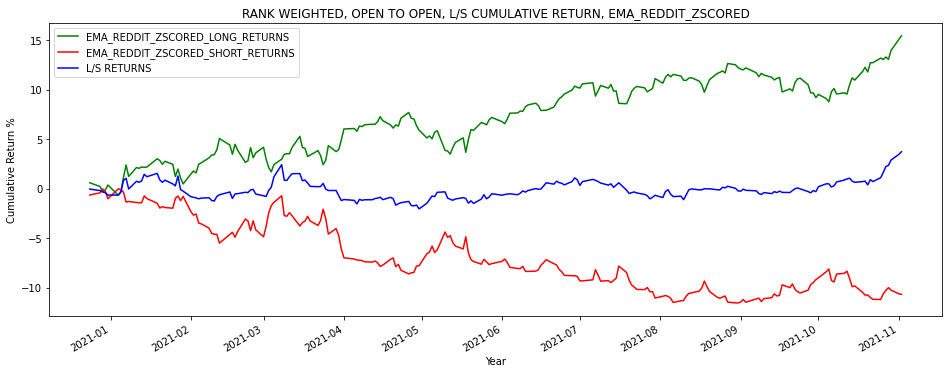

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS    18.08%     9.0%          15.45%    -3.9%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  -12.25%    9.31%         -10.67%  -11.54%   
L/S RETURNS                         4.34%    5.67%           3.73%   -4.36%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          1.89          2.82         4.63  
EMA_REDDIT_ZSCORED_SHORT_RETURNS        -1.36         -1.81        -1.06  
L/S RETURNS                              0.78          1.12         0.99

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 68.98 
 
 
 MSI 
 66.20 
 
 
 TXN 
 62.04 
 
 
 MPWR 
 60.19 
 
 
 HPQ 
 59.26 
 
 
 AVGO 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 TRMB 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 TDY 
 57.41 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 GPN 
 68.52 
 
 
 CTXS 
 63.89 
 
 
 CSCO 
 62.96 
 
 
 IPGP 
 61.57 
 
 
 ADI 
 60.19 
 
 
 WDC 
 59.72 
 
 
 IBM 
 59.72 
 
 
 FIS 
 59.72 
 
 
 FLT 
 59.26 
 
 
 FISV 
 56.94

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


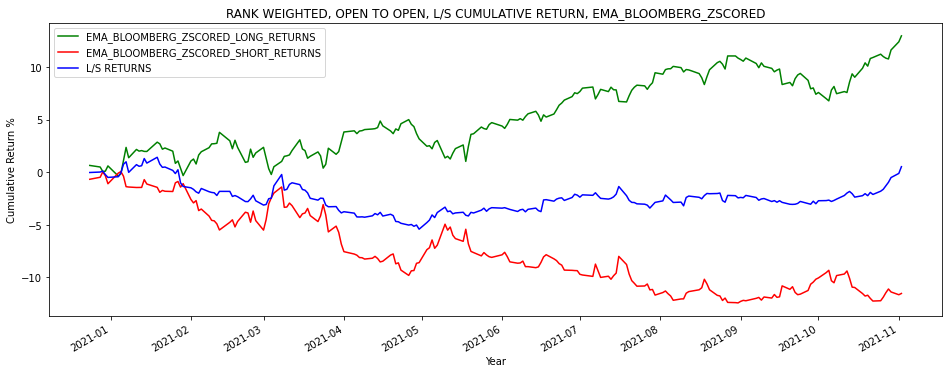

CAGR Ann. Vol Cumulative Ret.  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    15.15%    8.76%          12.96%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -13.22%    9.42%         -11.53%   
L/S RETURNS                            0.61%    5.61%           0.53%   

                                         MDD Sharpe Ratio Sortino Ratio  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    -3.86%         1.66          2.47   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -12.48%        -1.46         -1.96   
L/S RETURNS                           -6.74%         0.14           0.2   

                                    Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          3.92  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.06  
L/S RETURNS                                 0.09

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 66.20 
 
 
 IT 
 59.72 
 
 
 MPWR 
 58.33 
 
 
 NVDA 
 57.87 
 
 
 INTU 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 ZBRA 
 56.02 
 
 
 ANET 
 55.09 
 
 
 XLNX 
 54.63 
 
 
 KLAC 
 54.63 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 62.50 
 
 
 AKAM 
 59.26 
 
 
 GPN 
 57.87 
 
 
 CTSH 
 56.94 
 
 
 NLOK 
 56.94 
 
 
 VRSN 
 56.48 
 
 
 ANSS 
 55.09 
 
 
 HPQ 
 54.17 
 
 
 WU 
 54.17 
 
 
 TDY 
 53.70

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


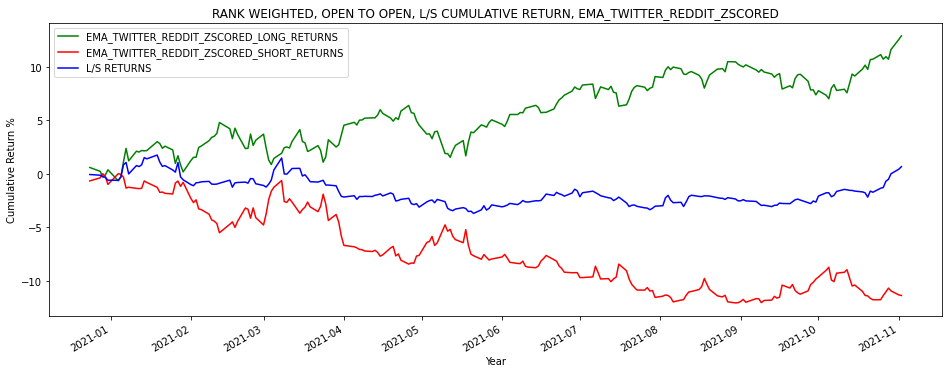

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    15.08%     9.1%           12.9%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -13.03%    9.18%         -11.36%   
L/S RETURNS                                 0.79%    5.32%           0.68%   

                                              MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    -4.55%         1.59          2.31   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -12.08%        -1.47         -1.97   
L/S RETURNS                                -5.36%         0.17          0.24   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          3.31  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS        -1.08  
L/S RETURNS                                      0.15

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.83 
 
 
 MSI 
 65.28 
 
 
 HPQ 
 65.28 
 
 
 MPWR 
 61.57 
 
 
 ANET 
 59.26 
 
 
 AKAM 
 58.80 
 
 
 IT 
 56.94 
 
 
 INTU 
 56.94 
 
 
 TRMB 
 56.94 
 
 
 TXN 
 56.48 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 66.20 
 
 
 GPN 
 63.43 
 
 
 FISV 
 59.72 
 
 
 FIS 
 59.72 
 
 
 IPGP 
 58.80 
 
 
 WU 
 57.41 
 
 
 FLT 
 56.94 
 
 
 JNPR 
 56.94 
 
 
 WDC 
 56.94 
 
 
 PYPL 
 56.94

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.21


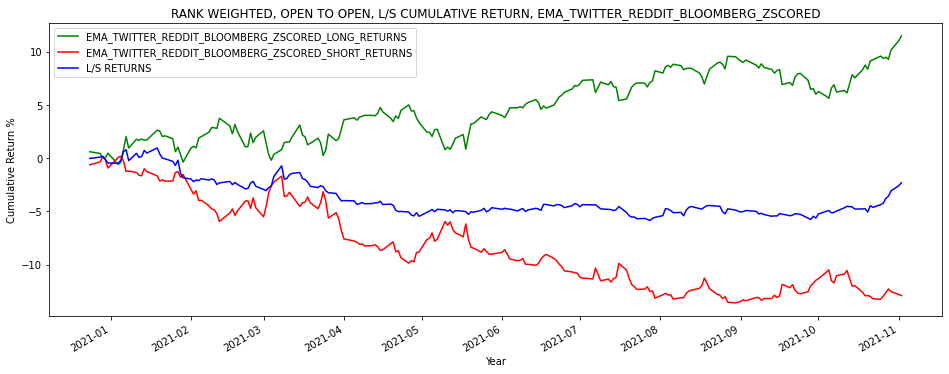

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS    13.41%    8.91%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -14.77%    9.01%   
L/S RETURNS                                          -2.66%    4.81%   

                                                   Cumulative Ret.      MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS           11.49%   -4.01%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         -12.89%  -13.73%   
L/S RETURNS                                                 -2.31%   -6.75%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          1.46          2.12   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.73         -2.28   
L/S RETURNS                                               -0.54         -0.74   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          3.34  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.08  
L/S RETURNS                                               -0.39

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 71.76 
 
 
 MSI 
 58.80 
 
 
 MPWR 
 58.33 
 
 
 IT 
 57.87 
 
 
 TYL 
 56.02 
 
 
 ANET 
 56.02 
 
 
 AVGO 
 55.56 
 
 
 TXN 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 CDNS 
 54.63 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 65.74 
 
 
 ADBE 
 57.87 
 
 
 GPN 
 56.94 
 
 
 WU 
 56.48 
 
 
 FIS 
 56.48 
 
 
 WDC 
 55.56 
 
 
 KEYS 
 55.56 
 
 
 CTSH 
 54.63 
 
 
 IPGP 
 54.17 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.22


In [24]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_rank(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                    
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('RANK WEIGHTED, OPEN TO OPEN, L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000 -0.041225   0.083567    -0.062269       0.016528   
REDDIT        -0.041225  1.000000  -0.099822     0.057143      -0.142720   
BLOOMBERG      0.083567 -0.099822   1.000000     0.224504      -0.024562   
EMA_ZSCORED   -0.062269  0.057143   0.224504     1.000000      -0.118616   
EQUAL_RETURNS  0.016528 -0.142720  -0.024562    -0.118616       1.000000   
XLK_RETURNS    0.052388 -0.155348   0.028017    -0.100553       0.884616   

               XLK_RETURNS  
TWITTER           0.052388  
REDDIT           -0.155348  
BLOOMBERG         0.028017  
EMA_ZSCORED      -0.100553  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

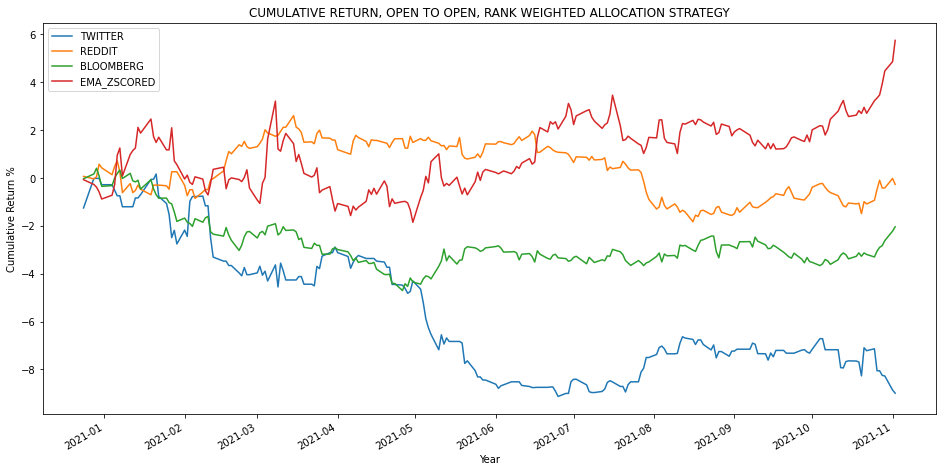

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -10.33%    5.88%          -8.99%  -9.28%        -1.82   
REDDIT        -0.31%    3.86%          -0.27%  -4.32%        -0.06   
BLOOMBERG     -2.36%    3.53%          -2.04%  -5.09%        -0.66   
EMA_ZSCORED    6.68%    7.23%           5.75%  -4.91%         0.93   

            Sortino Ratio Calmar Ratio  
TWITTER             -2.39        -1.11  
REDDIT              -0.09        -0.07  
BLOOMBERG           -0.91        -0.46  
EMA_ZSCORED          1.36         1.36

In [25]:
singles = zscore_returns[0:4]

singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN, OPEN TO OPEN, RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))

TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.096587   
EMA_REDDIT_ZSCORED                                    0.183395   
EMA_BLOOMBERG_ZSCORED                                 0.275266   
EMA_TWITTER_REDDIT_ZSCORED                            0.271455   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.535964   
EQUAL_RETURNS                                         0.051189   
XLK_RETURNS                                           0.084151   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.096587            0.183395   
EMA_TWITTER_ZSCORED                              1.000000            0.877093   
EMA_REDDIT_ZSCORED                               0.877093            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.878714            0.806390   
EMA_TWITTER_REDDIT_ZSCORED                       0.917091            0.960337   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.848705            0.849861   
EQUAL_RETURNS                                   -0.057542           -0.112066   
XLK_RETURNS                                     -0.036701           -0.102712   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.275266   
EMA_TWITTER_ZSCORED                                0.878714   
EMA_REDDIT_ZSCORED                                 0.806390   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.791235   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.913953   
EQUAL_RETURNS                                     -0.093436   
XLK_RETURNS                                       -0.052124   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.271455   
EMA_TWITTER_ZSCORED                                     0.917091   
EMA_REDDIT_ZSCORED                                      0.960337   
EMA_BLOOMBERG_ZSCORED                                   0.791235   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.886890   
EQUAL_RETURNS                                          -0.056147   
XLK_RETURNS                                            -0.050303   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.535964   
EMA_TWITTER_ZSCORED                                               0.848705   
EMA_REDDIT_ZSCORED                                                0.849861   
EMA_BLOOMBERG_ZSCORED                                             0.913953   
EMA_TWITTER_REDDIT_ZSCORED                                        0.886890   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.030676   
XLK_RETURNS                                                      -0.002180   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                   0.051189     0.084151  
EMA_TWITTER_ZSCORED                       -0.057542    -0.036701  
EMA_REDDIT_ZSCORED                        -0.112066    -0.102712  
EMA_BLOOMBERG_ZSCORED                     -0.093436    -0.052124  
EMA_TWITTER_REDDIT_ZSCORED                -0.056147    -0.050303  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.030676    -0.002180  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

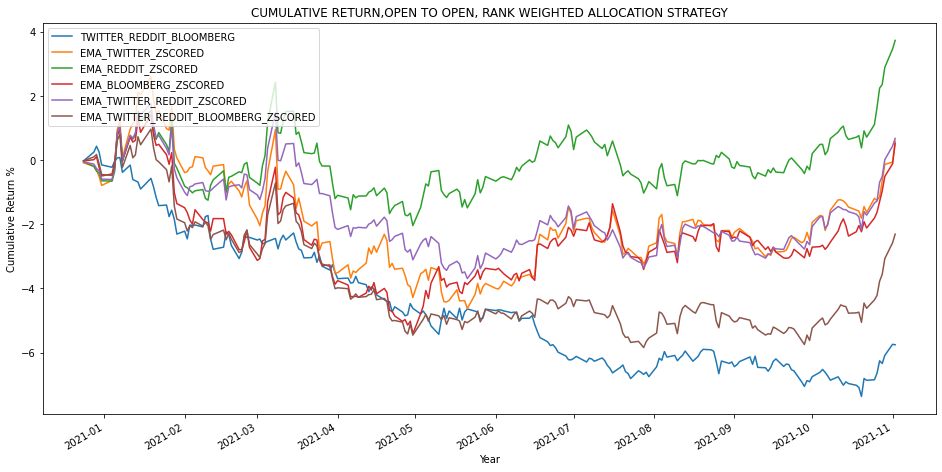

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -6.63%    3.39%          -5.75%  -7.77%   
EMA_TWITTER_ZSCORED                    0.68%    6.33%           0.59%  -7.05%   
EMA_REDDIT_ZSCORED                     4.34%    5.67%           3.73%  -4.36%   
EMA_BLOOMBERG_ZSCORED                  0.61%    5.61%           0.53%  -6.74%   
EMA_TWITTER_REDDIT_ZSCORED             0.79%    5.32%           0.68%  -5.36%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  -2.66%    4.81%          -2.31%  -6.75%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -2.01         -2.63        -0.85  
EMA_TWITTER_ZSCORED                          0.14          0.19          0.1  
EMA_REDDIT_ZSCORED                           0.78          1.12         0.99  
EMA_BLOOMBERG_ZSCORED                        0.14           0.2         0.09  
EMA_TWITTER_REDDIT_ZSCORED                   0.17          0.24         0.15  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED        -0.54         -0.74        -0.39

In [26]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN,OPEN TO OPEN, RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))